## Bike Rental Prediction with ANN: Learning Rate = 1e-1

This project aims at predicting bike rental rate based on weather and holiday information. The dataset contains hourly count of public bikes rented in Seoul Bike Sharing System, along with the corresponding weather data and holidays information, and is available at: https://archive.ics.uci.edu/ml/machine-learning-databases/00560/SeoulBikeData.csv

In this notebook, we train an artificial neural network with learning rate = 1e-1 to make predictions

In [1]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

In [2]:
# reading feature-engineered saved data file
df = pd.read_pickle('data_feat_eng.pkl')

In [3]:
df.head()

,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Month,Year,No Holiday,Funct_Day
0,254,0,-5.2,37,2.2,2000,-17.6,0,0,0,12,0,1,1
1,204,1,-5.5,38,0.8,2000,-17.6,0,0,0,12,0,1,1
2,173,2,-6.0,39,1.0,2000,-17.7,0,0,0,12,0,1,1
3,107,3,-6.2,40,0.9,2000,-17.6,0,0,0,12,0,1,1
4,78,4,-6.0,36,2.3,2000,-18.6,0,0,0,12,0,1,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Rented Bike Count          8760 non-null   int64  
 1   Hour                       8760 non-null   int64  
 2   Temperature(°C)            8760 non-null   float64
 3   Humidity(%)                8760 non-null   int64  
 4   Wind speed (m/s)           8760 non-null   float64
 5   Visibility (10m)           8760 non-null   int64  
 6   Dew point temperature(°C)  8760 non-null   float64
 7   Solar Radiation (MJ/m2)    8760 non-null   int64  
 8   Rainfall(mm)               8760 non-null   int64  
 9   Snowfall (cm)              8760 non-null   int64  
 10  Month                      8760 non-null   int64  
 11  Year                       8760 non-null   int64  
 12  No Holiday                 8760 non-null   uint8  
 13  Funct_Day                  8760 non-null   uint8

There are 13 numerical features

### Train-Test Splitting of Data

In [5]:
# features and labels are singled out of the dataframe

X = df.drop(['Rented Bike Count'],axis=1)
y = df['Rented Bike Count']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

### Data pre-processing

Pairwise correlation of features, if high, may suggest throwing away some of the features

Text(0.5, 1.0, 'Pairwise Correlation of Featues')

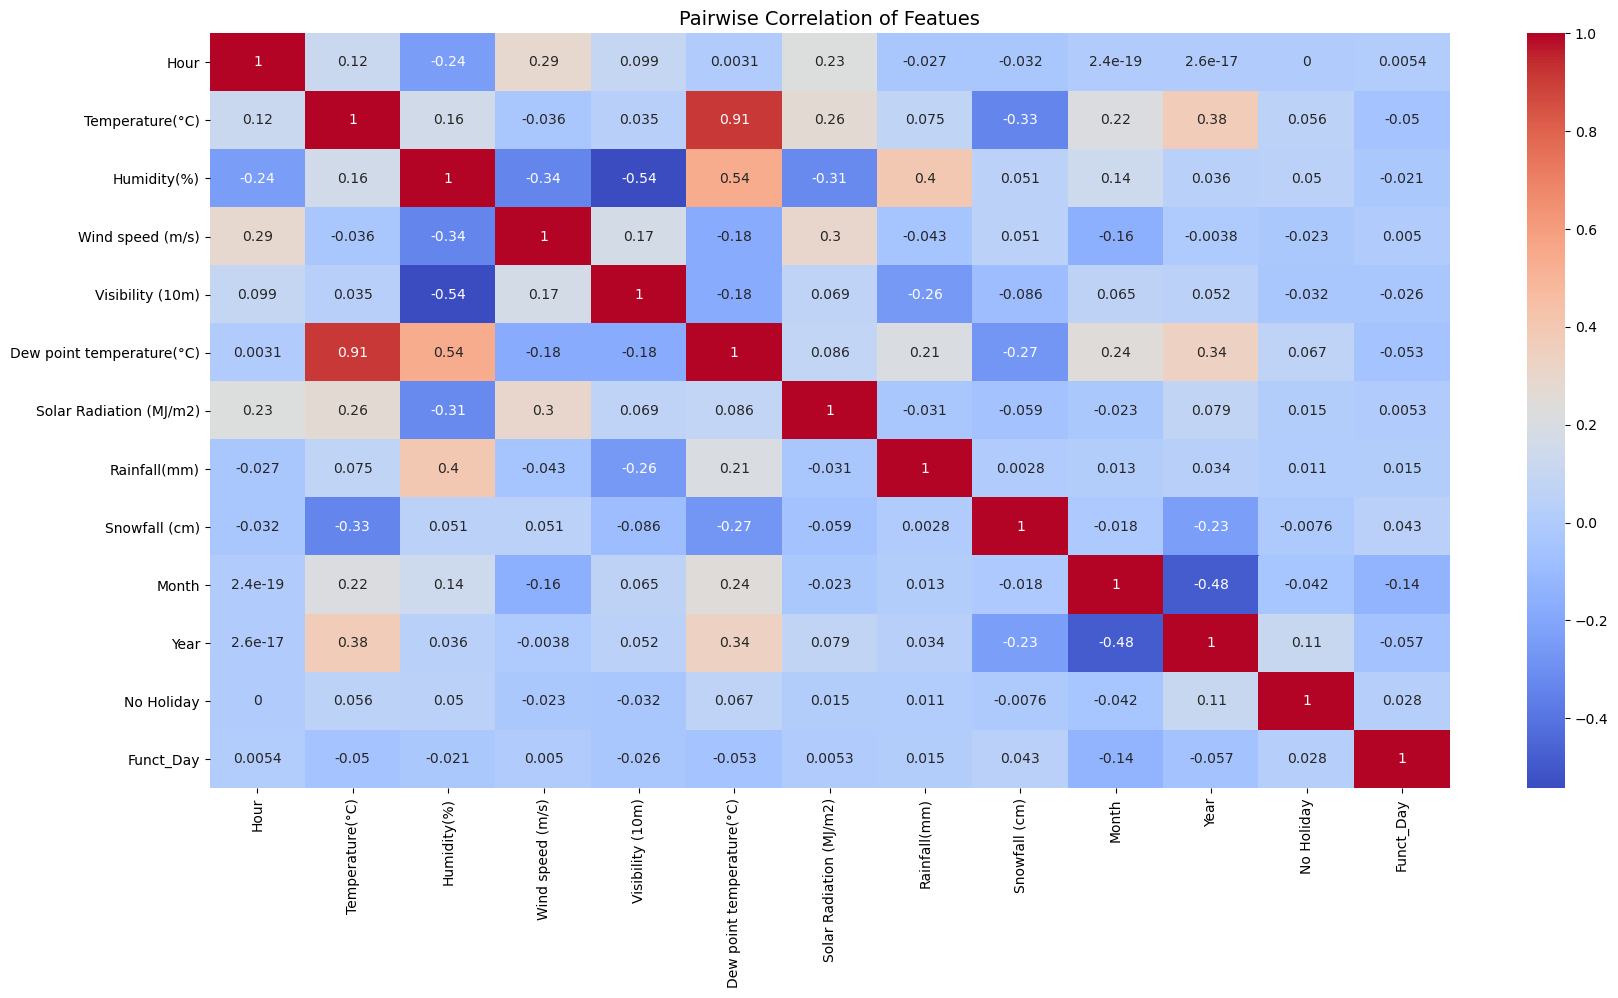

In [6]:
# pairwise correlation of featues
plt.figure(figsize=(20,10),dpi=100)
sns.heatmap(X.corr(),cmap='coolwarm',annot=True)
plt.title('Pairwise Correlation of Featues', fontsize=14)

There is a single highly correlated pair. We may need to perform PCA

#### Principal Component Analysis

In [7]:
from sklearn.preprocessing import MinMaxScaler

# feature scaling
sc = MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

To see how many principal components may be needed, let us plot cumulative explained variance

Text(0, 0.5, 'Cumulative explained variance')

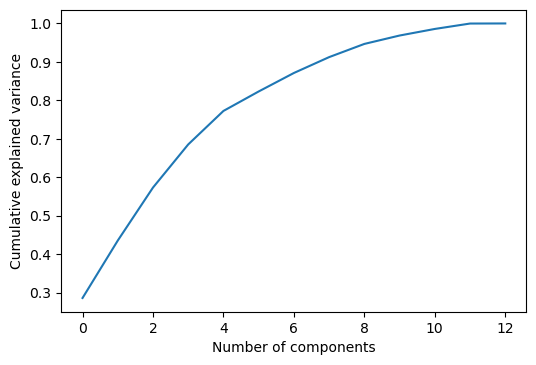

In [8]:
from sklearn.decomposition import PCA

# making the list of cumulative explained variance
pca = PCA().fit(X_train)
cumsum_list = pca.explained_variance_ratio_.cumsum()

# making the plot of cumulative explained variance
plt.figure(dpi=100)
plt.plot(cumsum_list)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

We will retain as many principal components as account for 99% cumulative variance:

In [9]:
pc_model = PCA(n_components=0.99, svd_solver='full')
pc_model.fit(X_train)
pc_model.n_components_ 

12

This rids of one more feature. Now we select out the proncipal components

In [10]:
# principal component selection
X_train = pc_model.fit_transform(X_train)
X_test = pc_model.transform(X_test)

Next we create an artificial neural network for training

### Creating the Model

In [11]:
# import tensorflow and check version
import tensorflow as tf
tf.__version__

'2.4.1'

In [12]:
# imports for network architecture
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [13]:
def create_ann():
    '''This function creates an ANN model'''
    
    # start neural network
    model = Sequential()
    
    model.add(Dense(12, activation='relu')) # input layer
    
    model.add(Dense(12, activation='relu')) # first hidden layer
    
    model.add(Dense(12, activation='relu')) # second hidden layer
    
    model.add(Dense(1))                    # output layer
    
    # compile neural network
    opt = tf.keras.optimizers.Adam(learning_rate=0.1) # default learning_rate = 0.001
    model.compile(optimizer=opt,loss='mae')
    
    # return compiled network
    return model

In [14]:
# model created
ann = create_ann()

Now we will train the ANN with validation_split = 0.1, batch_size = 128, for 10_000 epochs

In [15]:
import time
t1 = time.time()

# training the model
ann.fit(x=X_train, y=y_train, validation_split=0.1, batch_size=128, epochs=10_000)

t2 = time.time()

Epoch 1/10000
50/50 [==============================] - 2s 24ms/step - loss: 547.4476 - val_loss: 272.6617
Epoch 2/10000
50/50 [==============================] - 0s 2ms/step - loss: 262.3980 - val_loss: 254.1039
Epoch 3/10000
50/50 [==============================] - 0s 2ms/step - loss: 243.4951 - val_loss: 227.8020
Epoch 4/10000
50/50 [==============================] - 0s 2ms/step - loss: 229.2356 - val_loss: 215.7263
Epoch 5/10000
50/50 [==============================] - 0s 2ms/step - loss: 214.5017 - val_loss: 213.3426
Epoch 6/10000
50/50 [==============================] - 0s 2ms/step - loss: 227.5207 - val_loss: 214.4801
Epoch 7/10000
50/50 [==============================] - 0s 2ms/step - loss: 214.9072 - val_loss: 214.4682
Epoch 8/10000
50/50 [==============================] - 0s 1ms/step - loss: 215.6239 - val_loss: 213.0801
Epoch 9/10000
50/50 [==============================] - 0s 2ms/step - loss: 213.5375 - val_loss: 208.4948
Epoch 10/10000
50/50 [==============================] 

50/50 [==============================] - 0s 2ms/step - loss: 171.2096 - val_loss: 162.8716
Epoch 79/10000
50/50 [==============================] - 0s 2ms/step - loss: 173.5949 - val_loss: 163.2140
Epoch 80/10000
50/50 [==============================] - 0s 2ms/step - loss: 168.9700 - val_loss: 162.1527
Epoch 81/10000
50/50 [==============================] - 0s 2ms/step - loss: 171.9161 - val_loss: 164.5567
Epoch 82/10000
50/50 [==============================] - 0s 2ms/step - loss: 174.0950 - val_loss: 165.5858
Epoch 83/10000
50/50 [==============================] - 0s 2ms/step - loss: 165.6634 - val_loss: 162.7992
Epoch 84/10000
50/50 [==============================] - 0s 2ms/step - loss: 169.2009 - val_loss: 160.4039
Epoch 85/10000
50/50 [==============================] - 0s 2ms/step - loss: 169.5967 - val_loss: 161.7086
Epoch 86/10000
50/50 [==============================] - 0s 2ms/step - loss: 172.8261 - val_loss: 160.9644
Epoch 87/10000
50/50 [==============================] - 0s 2m

Epoch 155/10000
50/50 [==============================] - 0s 2ms/step - loss: 168.6944 - val_loss: 154.5067
Epoch 156/10000
50/50 [==============================] - 0s 2ms/step - loss: 162.1986 - val_loss: 163.2484
Epoch 157/10000
50/50 [==============================] - 0s 2ms/step - loss: 167.3148 - val_loss: 159.9003
Epoch 158/10000
50/50 [==============================] - 0s 2ms/step - loss: 168.0854 - val_loss: 158.9580
Epoch 159/10000
50/50 [==============================] - 0s 2ms/step - loss: 164.3197 - val_loss: 158.8693
Epoch 160/10000
50/50 [==============================] - 0s 2ms/step - loss: 164.6954 - val_loss: 156.9077
Epoch 161/10000
50/50 [==============================] - 0s 2ms/step - loss: 163.4653 - val_loss: 156.6951
Epoch 162/10000
50/50 [==============================] - 0s 2ms/step - loss: 159.3207 - val_loss: 155.5614
Epoch 163/10000
50/50 [==============================] - 0s 2ms/step - loss: 159.5316 - val_loss: 155.9554
Epoch 164/10000
50/50 [==============

50/50 [==============================] - 0s 3ms/step - loss: 158.9132 - val_loss: 158.0629
Epoch 232/10000
50/50 [==============================] - 0s 2ms/step - loss: 153.3203 - val_loss: 155.0572
Epoch 233/10000
50/50 [==============================] - 0s 2ms/step - loss: 160.6103 - val_loss: 157.6866
Epoch 234/10000
50/50 [==============================] - 0s 2ms/step - loss: 164.9731 - val_loss: 155.6229
Epoch 235/10000
50/50 [==============================] - 0s 2ms/step - loss: 162.1593 - val_loss: 154.9493
Epoch 236/10000
50/50 [==============================] - 0s 2ms/step - loss: 162.9112 - val_loss: 159.5825
Epoch 237/10000
50/50 [==============================] - 0s 2ms/step - loss: 162.9446 - val_loss: 158.6810
Epoch 238/10000
50/50 [==============================] - 0s 2ms/step - loss: 162.3770 - val_loss: 153.0604
Epoch 239/10000
50/50 [==============================] - 0s 2ms/step - loss: 161.1904 - val_loss: 152.5691
Epoch 240/10000
50/50 [==============================

50/50 [==============================] - 0s 3ms/step - loss: 169.4420 - val_loss: 156.6092
Epoch 308/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.0185 - val_loss: 153.6598
Epoch 309/10000
50/50 [==============================] - 0s 3ms/step - loss: 165.0487 - val_loss: 162.6501
Epoch 310/10000
50/50 [==============================] - 0s 3ms/step - loss: 162.1283 - val_loss: 167.1823
Epoch 311/10000
50/50 [==============================] - 0s 3ms/step - loss: 164.3051 - val_loss: 156.7685
Epoch 312/10000
50/50 [==============================] - 0s 3ms/step - loss: 160.0572 - val_loss: 156.7627
Epoch 313/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.1342 - val_loss: 155.2974
Epoch 314/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.0626 - val_loss: 161.1090
Epoch 315/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.5309 - val_loss: 156.8422
Epoch 316/10000
50/50 [==============================

50/50 [==============================] - 0s 3ms/step - loss: 160.9990 - val_loss: 154.4490
Epoch 384/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.5122 - val_loss: 159.1105
Epoch 385/10000
50/50 [==============================] - 0s 3ms/step - loss: 163.8028 - val_loss: 159.1954
Epoch 386/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.6272 - val_loss: 158.6983
Epoch 387/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.5596 - val_loss: 156.2805
Epoch 388/10000
50/50 [==============================] - 0s 3ms/step - loss: 160.1937 - val_loss: 156.0292
Epoch 389/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.0245 - val_loss: 154.4916
Epoch 390/10000
50/50 [==============================] - 0s 3ms/step - loss: 160.7007 - val_loss: 166.1399
Epoch 391/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.8010 - val_loss: 155.8421
Epoch 392/10000
50/50 [==============================

50/50 [==============================] - 0s 3ms/step - loss: 159.6701 - val_loss: 153.0009
Epoch 460/10000
50/50 [==============================] - 0s 3ms/step - loss: 164.4786 - val_loss: 154.1143
Epoch 461/10000
50/50 [==============================] - 0s 3ms/step - loss: 164.5732 - val_loss: 156.0566
Epoch 462/10000
50/50 [==============================] - 0s 3ms/step - loss: 160.0472 - val_loss: 154.2669
Epoch 463/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.2333 - val_loss: 158.4822
Epoch 464/10000
50/50 [==============================] - 0s 3ms/step - loss: 160.5029 - val_loss: 155.0357
Epoch 465/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.0941 - val_loss: 157.9339
Epoch 466/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.9250 - val_loss: 154.5122
Epoch 467/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.5399 - val_loss: 151.7095
Epoch 468/10000
50/50 [==============================

50/50 [==============================] - 0s 4ms/step - loss: 163.7136 - val_loss: 154.0717
Epoch 536/10000
50/50 [==============================] - 0s 3ms/step - loss: 161.1590 - val_loss: 157.4886
Epoch 537/10000
50/50 [==============================] - 0s 3ms/step - loss: 162.2530 - val_loss: 158.5921
Epoch 538/10000
50/50 [==============================] - 0s 3ms/step - loss: 161.3946 - val_loss: 166.9065
Epoch 539/10000
50/50 [==============================] - 0s 3ms/step - loss: 166.3822 - val_loss: 165.5619
Epoch 540/10000
50/50 [==============================] - 0s 3ms/step - loss: 160.0090 - val_loss: 156.0530
Epoch 541/10000
50/50 [==============================] - 0s 4ms/step - loss: 159.1196 - val_loss: 155.7597
Epoch 542/10000
50/50 [==============================] - 0s 4ms/step - loss: 159.2469 - val_loss: 159.9332
Epoch 543/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.1508 - val_loss: 152.9395
Epoch 544/10000
50/50 [==============================

50/50 [==============================] - 0s 3ms/step - loss: 155.4098 - val_loss: 155.9774
Epoch 612/10000
50/50 [==============================] - 0s 3ms/step - loss: 158.6089 - val_loss: 155.2573
Epoch 613/10000
50/50 [==============================] - 0s 3ms/step - loss: 155.8562 - val_loss: 158.7960
Epoch 614/10000
50/50 [==============================] - 0s 3ms/step - loss: 160.1432 - val_loss: 154.9905
Epoch 615/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.2693 - val_loss: 155.8255
Epoch 616/10000
50/50 [==============================] - 0s 3ms/step - loss: 161.5473 - val_loss: 154.6463
Epoch 617/10000
50/50 [==============================] - 0s 3ms/step - loss: 160.4289 - val_loss: 156.6212
Epoch 618/10000
50/50 [==============================] - 0s 3ms/step - loss: 160.3439 - val_loss: 156.3533
Epoch 619/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.6491 - val_loss: 157.6223
Epoch 620/10000
50/50 [==============================

50/50 [==============================] - 0s 3ms/step - loss: 160.5868 - val_loss: 154.3122
Epoch 688/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.9003 - val_loss: 156.3793
Epoch 689/10000
50/50 [==============================] - 0s 3ms/step - loss: 158.0290 - val_loss: 170.3668
Epoch 690/10000
50/50 [==============================] - 0s 3ms/step - loss: 161.8401 - val_loss: 153.6111
Epoch 691/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.1005 - val_loss: 154.2760
Epoch 692/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.4986 - val_loss: 159.0064
Epoch 693/10000
50/50 [==============================] - 0s 3ms/step - loss: 158.0887 - val_loss: 159.1279
Epoch 694/10000
50/50 [==============================] - 0s 3ms/step - loss: 160.4361 - val_loss: 165.0903
Epoch 695/10000
50/50 [==============================] - 0s 3ms/step - loss: 163.2775 - val_loss: 157.1475
Epoch 696/10000
50/50 [==============================

50/50 [==============================] - 0s 3ms/step - loss: 161.8052 - val_loss: 154.6948
Epoch 764/10000
50/50 [==============================] - 0s 3ms/step - loss: 163.8315 - val_loss: 155.2809
Epoch 765/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.9661 - val_loss: 159.1871
Epoch 766/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.3330 - val_loss: 156.1562
Epoch 767/10000
50/50 [==============================] - 0s 3ms/step - loss: 160.6910 - val_loss: 156.9936
Epoch 768/10000
50/50 [==============================] - 0s 4ms/step - loss: 157.1713 - val_loss: 156.4034
Epoch 769/10000
50/50 [==============================] - 0s 3ms/step - loss: 155.5170 - val_loss: 156.1610
Epoch 770/10000
50/50 [==============================] - 0s 3ms/step - loss: 161.6331 - val_loss: 158.0477
Epoch 771/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.0229 - val_loss: 157.6929
Epoch 772/10000
50/50 [==============================

50/50 [==============================] - 0s 3ms/step - loss: 157.4395 - val_loss: 159.2812
Epoch 840/10000
50/50 [==============================] - 0s 4ms/step - loss: 157.9641 - val_loss: 153.4332
Epoch 841/10000
50/50 [==============================] - 0s 4ms/step - loss: 160.1741 - val_loss: 157.2209
Epoch 842/10000
50/50 [==============================] - 0s 4ms/step - loss: 162.8946 - val_loss: 158.1975
Epoch 843/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.1157 - val_loss: 153.9503
Epoch 844/10000
50/50 [==============================] - 0s 4ms/step - loss: 159.2683 - val_loss: 156.6689
Epoch 845/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.2643 - val_loss: 156.3522
Epoch 846/10000
50/50 [==============================] - 0s 4ms/step - loss: 155.8743 - val_loss: 154.2389
Epoch 847/10000
50/50 [==============================] - 0s 3ms/step - loss: 158.9463 - val_loss: 160.8418
Epoch 848/10000
50/50 [==============================

50/50 [==============================] - 0s 4ms/step - loss: 155.3857 - val_loss: 155.7306
Epoch 916/10000
50/50 [==============================] - 0s 3ms/step - loss: 154.2348 - val_loss: 155.4722
Epoch 917/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.6847 - val_loss: 159.3631
Epoch 918/10000
50/50 [==============================] - 0s 3ms/step - loss: 155.4248 - val_loss: 161.3945
Epoch 919/10000
50/50 [==============================] - 0s 3ms/step - loss: 162.8036 - val_loss: 161.0824
Epoch 920/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.6402 - val_loss: 154.0052
Epoch 921/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.5585 - val_loss: 156.0831
Epoch 922/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.3752 - val_loss: 162.3153
Epoch 923/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.0812 - val_loss: 155.0995
Epoch 924/10000
50/50 [==============================

50/50 [==============================] - 0s 3ms/step - loss: 165.2478 - val_loss: 155.5512
Epoch 992/10000
50/50 [==============================] - 0s 3ms/step - loss: 164.6641 - val_loss: 162.6263
Epoch 993/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.5149 - val_loss: 155.0990
Epoch 994/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.6322 - val_loss: 165.8816
Epoch 995/10000
50/50 [==============================] - 0s 3ms/step - loss: 161.8242 - val_loss: 159.2859
Epoch 996/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.6755 - val_loss: 156.1735
Epoch 997/10000
50/50 [==============================] - 0s 3ms/step - loss: 161.5580 - val_loss: 153.5175
Epoch 998/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.3279 - val_loss: 162.8985
Epoch 999/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.0226 - val_loss: 158.8932
Epoch 1000/10000
50/50 [=============================

50/50 [==============================] - 0s 3ms/step - loss: 162.8117 - val_loss: 154.8209
Epoch 1068/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.5070 - val_loss: 155.0968
Epoch 1069/10000
50/50 [==============================] - 0s 3ms/step - loss: 155.8200 - val_loss: 151.8742
Epoch 1070/10000
50/50 [==============================] - 0s 3ms/step - loss: 154.6579 - val_loss: 154.7698
Epoch 1071/10000
50/50 [==============================] - 0s 3ms/step - loss: 158.8872 - val_loss: 155.0533
Epoch 1072/10000
50/50 [==============================] - 0s 3ms/step - loss: 160.0036 - val_loss: 154.6931
Epoch 1073/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.4646 - val_loss: 155.3736
Epoch 1074/10000
50/50 [==============================] - 0s 3ms/step - loss: 162.8947 - val_loss: 155.3002
Epoch 1075/10000
50/50 [==============================] - 0s 3ms/step - loss: 155.4484 - val_loss: 154.3947
Epoch 1076/10000
50/50 [=====================

50/50 [==============================] - 0s 5ms/step - loss: 157.5271 - val_loss: 157.8416
Epoch 1144/10000
50/50 [==============================] - 0s 5ms/step - loss: 155.0274 - val_loss: 156.5229
Epoch 1145/10000
50/50 [==============================] - 0s 5ms/step - loss: 165.8383 - val_loss: 160.9699
Epoch 1146/10000
50/50 [==============================] - 0s 7ms/step - loss: 159.4963 - val_loss: 154.8873
Epoch 1147/10000
50/50 [==============================] - 0s 7ms/step - loss: 164.3391 - val_loss: 165.1253
Epoch 1148/10000
50/50 [==============================] - 0s 7ms/step - loss: 159.1395 - val_loss: 158.8478
Epoch 1149/10000
50/50 [==============================] - 0s 8ms/step - loss: 165.9586 - val_loss: 160.6489
Epoch 1150/10000
50/50 [==============================] - 0s 5ms/step - loss: 160.4015 - val_loss: 153.7451
Epoch 1151/10000
50/50 [==============================] - 0s 5ms/step - loss: 158.9565 - val_loss: 172.8095
Epoch 1152/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 156.0573 - val_loss: 157.9613
Epoch 1220/10000
50/50 [==============================] - 0s 3ms/step - loss: 162.1419 - val_loss: 156.3479
Epoch 1221/10000
50/50 [==============================] - 0s 3ms/step - loss: 152.4039 - val_loss: 156.5131
Epoch 1222/10000
50/50 [==============================] - 0s 3ms/step - loss: 162.4746 - val_loss: 160.4126
Epoch 1223/10000
50/50 [==============================] - 0s 3ms/step - loss: 163.8211 - val_loss: 156.1759
Epoch 1224/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.2361 - val_loss: 155.6871
Epoch 1225/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.8538 - val_loss: 154.4627
Epoch 1226/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.6027 - val_loss: 155.5460
Epoch 1227/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.4745 - val_loss: 155.7713
Epoch 1228/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 157.1417 - val_loss: 154.0367
Epoch 1296/10000
50/50 [==============================] - 0s 3ms/step - loss: 160.5319 - val_loss: 154.3844
Epoch 1297/10000
50/50 [==============================] - 0s 3ms/step - loss: 155.1965 - val_loss: 154.8680
Epoch 1298/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.4662 - val_loss: 159.1764
Epoch 1299/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.1458 - val_loss: 160.2440
Epoch 1300/10000
50/50 [==============================] - 0s 3ms/step - loss: 155.2786 - val_loss: 154.9001
Epoch 1301/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.2506 - val_loss: 159.4939
Epoch 1302/10000
50/50 [==============================] - 0s 3ms/step - loss: 162.3060 - val_loss: 155.3550
Epoch 1303/10000
50/50 [==============================] - 0s 3ms/step - loss: 158.3874 - val_loss: 154.7687
Epoch 1304/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 153.3473 - val_loss: 160.5733
Epoch 1372/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.2770 - val_loss: 159.8980
Epoch 1373/10000
50/50 [==============================] - 0s 3ms/step - loss: 158.3302 - val_loss: 158.5742
Epoch 1374/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.7407 - val_loss: 157.8533
Epoch 1375/10000
50/50 [==============================] - 0s 3ms/step - loss: 154.8972 - val_loss: 161.6859
Epoch 1376/10000
50/50 [==============================] - 0s 3ms/step - loss: 160.5865 - val_loss: 156.5099
Epoch 1377/10000
50/50 [==============================] - 0s 3ms/step - loss: 161.1767 - val_loss: 156.5759
Epoch 1378/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.0483 - val_loss: 156.3352
Epoch 1379/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.2008 - val_loss: 159.6655
Epoch 1380/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 161.6907 - val_loss: 159.1558
Epoch 1448/10000
50/50 [==============================] - 0s 3ms/step - loss: 161.5209 - val_loss: 153.6416
Epoch 1449/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.6292 - val_loss: 164.4268
Epoch 1450/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.5912 - val_loss: 156.6555
Epoch 1451/10000
50/50 [==============================] - 0s 3ms/step - loss: 160.8315 - val_loss: 154.9490
Epoch 1452/10000
50/50 [==============================] - 0s 3ms/step - loss: 160.8825 - val_loss: 155.0311
Epoch 1453/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.1781 - val_loss: 154.1963
Epoch 1454/10000
50/50 [==============================] - 0s 3ms/step - loss: 160.4356 - val_loss: 154.4359
Epoch 1455/10000
50/50 [==============================] - 0s 3ms/step - loss: 160.5872 - val_loss: 156.6548
Epoch 1456/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 158.3757 - val_loss: 155.4621
Epoch 1524/10000
50/50 [==============================] - 0s 4ms/step - loss: 155.3829 - val_loss: 155.2969
Epoch 1525/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.5502 - val_loss: 154.6089
Epoch 1526/10000
50/50 [==============================] - 0s 3ms/step - loss: 158.6064 - val_loss: 155.2025
Epoch 1527/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.8275 - val_loss: 157.3324
Epoch 1528/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.3754 - val_loss: 154.4265
Epoch 1529/10000
50/50 [==============================] - 0s 3ms/step - loss: 152.6799 - val_loss: 153.4762
Epoch 1530/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.5023 - val_loss: 155.5074
Epoch 1531/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.0872 - val_loss: 152.7292
Epoch 1532/10000
50/50 [=====================

50/50 [==============================] - 0s 4ms/step - loss: 157.8328 - val_loss: 156.4278
Epoch 1600/10000
50/50 [==============================] - 0s 4ms/step - loss: 154.2987 - val_loss: 157.1689
Epoch 1601/10000
50/50 [==============================] - 0s 4ms/step - loss: 157.8646 - val_loss: 156.9477
Epoch 1602/10000
50/50 [==============================] - 0s 4ms/step - loss: 158.2089 - val_loss: 168.9892
Epoch 1603/10000
50/50 [==============================] - 0s 4ms/step - loss: 159.5845 - val_loss: 154.1755
Epoch 1604/10000
50/50 [==============================] - 0s 4ms/step - loss: 155.4123 - val_loss: 163.7059
Epoch 1605/10000
50/50 [==============================] - 0s 4ms/step - loss: 158.4988 - val_loss: 155.4113
Epoch 1606/10000
50/50 [==============================] - 0s 4ms/step - loss: 154.1157 - val_loss: 158.6728
Epoch 1607/10000
50/50 [==============================] - 0s 4ms/step - loss: 159.8782 - val_loss: 154.6902
Epoch 1608/10000
50/50 [=====================

50/50 [==============================] - 0s 6ms/step - loss: 157.5146 - val_loss: 158.4587
Epoch 1675/10000
50/50 [==============================] - 0s 4ms/step - loss: 155.7310 - val_loss: 153.9342
Epoch 1676/10000
50/50 [==============================] - 0s 4ms/step - loss: 156.4849 - val_loss: 164.3607
Epoch 1677/10000
50/50 [==============================] - 0s 4ms/step - loss: 157.9459 - val_loss: 153.5944
Epoch 1678/10000
50/50 [==============================] - 0s 3ms/step - loss: 158.2053 - val_loss: 160.5756
Epoch 1679/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.0802 - val_loss: 155.5152
Epoch 1680/10000
50/50 [==============================] - 0s 3ms/step - loss: 158.5051 - val_loss: 161.9207
Epoch 1681/10000
50/50 [==============================] - 0s 3ms/step - loss: 154.2418 - val_loss: 160.9342
Epoch 1682/10000
50/50 [==============================] - 0s 3ms/step - loss: 162.3832 - val_loss: 160.0470
Epoch 1683/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 153.8530 - val_loss: 155.2234
Epoch 1751/10000
50/50 [==============================] - 0s 3ms/step - loss: 153.9980 - val_loss: 156.8618
Epoch 1752/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.7225 - val_loss: 159.6377
Epoch 1753/10000
50/50 [==============================] - 0s 3ms/step - loss: 152.1491 - val_loss: 155.2581
Epoch 1754/10000
50/50 [==============================] - 0s 3ms/step - loss: 158.0102 - val_loss: 157.3140
Epoch 1755/10000
50/50 [==============================] - 0s 3ms/step - loss: 155.7951 - val_loss: 159.7950
Epoch 1756/10000
50/50 [==============================] - 0s 3ms/step - loss: 158.5778 - val_loss: 157.7687
Epoch 1757/10000
50/50 [==============================] - 0s 3ms/step - loss: 158.9113 - val_loss: 165.9636
Epoch 1758/10000
50/50 [==============================] - 0s 3ms/step - loss: 158.9884 - val_loss: 154.8137
Epoch 1759/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 159.6222 - val_loss: 156.0872
Epoch 1827/10000
50/50 [==============================] - 0s 3ms/step - loss: 167.3148 - val_loss: 152.8361
Epoch 1828/10000
50/50 [==============================] - 0s 3ms/step - loss: 160.8163 - val_loss: 155.8214
Epoch 1829/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.4202 - val_loss: 157.7859
Epoch 1830/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.0045 - val_loss: 153.9861
Epoch 1831/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.4676 - val_loss: 154.4434
Epoch 1832/10000
50/50 [==============================] - 0s 3ms/step - loss: 153.4500 - val_loss: 159.6043
Epoch 1833/10000
50/50 [==============================] - 0s 3ms/step - loss: 155.4227 - val_loss: 168.2808
Epoch 1834/10000
50/50 [==============================] - 0s 3ms/step - loss: 160.0545 - val_loss: 153.9115
Epoch 1835/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 152.3291 - val_loss: 156.9581
Epoch 1903/10000
50/50 [==============================] - 0s 3ms/step - loss: 154.3184 - val_loss: 161.7454
Epoch 1904/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.4353 - val_loss: 156.9660
Epoch 1905/10000
50/50 [==============================] - 0s 3ms/step - loss: 158.8870 - val_loss: 157.5336
Epoch 1906/10000
50/50 [==============================] - 0s 3ms/step - loss: 155.3653 - val_loss: 155.8862
Epoch 1907/10000
50/50 [==============================] - 0s 3ms/step - loss: 155.5571 - val_loss: 156.2157
Epoch 1908/10000
50/50 [==============================] - 0s 3ms/step - loss: 160.9971 - val_loss: 152.2084
Epoch 1909/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.5218 - val_loss: 162.1414
Epoch 1910/10000
50/50 [==============================] - 0s 3ms/step - loss: 160.2220 - val_loss: 158.6500
Epoch 1911/10000
50/50 [=====================

50/50 [==============================] - 0s 5ms/step - loss: 157.1755 - val_loss: 161.9601
Epoch 1978/10000
50/50 [==============================] - 0s 5ms/step - loss: 157.7753 - val_loss: 166.1165
Epoch 1979/10000
50/50 [==============================] - 0s 5ms/step - loss: 161.9724 - val_loss: 169.9195
Epoch 1980/10000
50/50 [==============================] - 0s 4ms/step - loss: 152.5185 - val_loss: 162.7652
Epoch 1981/10000
50/50 [==============================] - 0s 4ms/step - loss: 163.3086 - val_loss: 161.7972
Epoch 1982/10000
50/50 [==============================] - 0s 4ms/step - loss: 158.7211 - val_loss: 159.1410
Epoch 1983/10000
50/50 [==============================] - 0s 4ms/step - loss: 156.6943 - val_loss: 153.8422
Epoch 1984/10000
50/50 [==============================] - 0s 4ms/step - loss: 158.9066 - val_loss: 160.1639
Epoch 1985/10000
50/50 [==============================] - 0s 4ms/step - loss: 159.6949 - val_loss: 159.7836
Epoch 1986/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 158.3863 - val_loss: 160.4081
Epoch 2054/10000
50/50 [==============================] - 0s 3ms/step - loss: 155.6747 - val_loss: 158.7572
Epoch 2055/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.7798 - val_loss: 156.2384
Epoch 2056/10000
50/50 [==============================] - 0s 3ms/step - loss: 158.5083 - val_loss: 155.7476
Epoch 2057/10000
50/50 [==============================] - 0s 3ms/step - loss: 153.6832 - val_loss: 157.3453
Epoch 2058/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.2142 - val_loss: 157.5206
Epoch 2059/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.7630 - val_loss: 156.3013
Epoch 2060/10000
50/50 [==============================] - 0s 3ms/step - loss: 158.0513 - val_loss: 155.8002
Epoch 2061/10000
50/50 [==============================] - 0s 3ms/step - loss: 154.7412 - val_loss: 154.8683
Epoch 2062/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 159.2653 - val_loss: 157.1136
Epoch 2130/10000
50/50 [==============================] - 0s 4ms/step - loss: 153.8119 - val_loss: 152.6790
Epoch 2131/10000
50/50 [==============================] - 0s 3ms/step - loss: 161.5017 - val_loss: 157.5683
Epoch 2132/10000
50/50 [==============================] - 0s 3ms/step - loss: 165.8945 - val_loss: 157.0120
Epoch 2133/10000
50/50 [==============================] - 0s 3ms/step - loss: 155.2765 - val_loss: 154.2466
Epoch 2134/10000
50/50 [==============================] - 0s 3ms/step - loss: 162.1686 - val_loss: 154.7030
Epoch 2135/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.5862 - val_loss: 153.7634
Epoch 2136/10000
50/50 [==============================] - 0s 3ms/step - loss: 155.3128 - val_loss: 156.7721
Epoch 2137/10000
50/50 [==============================] - 0s 3ms/step - loss: 162.2980 - val_loss: 154.5344
Epoch 2138/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 162.7932 - val_loss: 155.6907
Epoch 2206/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.0588 - val_loss: 158.3146
Epoch 2207/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.6308 - val_loss: 157.2236
Epoch 2208/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.9045 - val_loss: 153.7791
Epoch 2209/10000
50/50 [==============================] - 0s 3ms/step - loss: 155.7227 - val_loss: 156.5835
Epoch 2210/10000
50/50 [==============================] - 0s 3ms/step - loss: 160.0145 - val_loss: 157.2606
Epoch 2211/10000
50/50 [==============================] - 0s 3ms/step - loss: 152.0347 - val_loss: 155.6272
Epoch 2212/10000
50/50 [==============================] - 0s 3ms/step - loss: 161.1706 - val_loss: 156.4201
Epoch 2213/10000
50/50 [==============================] - 0s 2ms/step - loss: 160.6504 - val_loss: 157.1318
Epoch 2214/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 155.9308 - val_loss: 154.2543
Epoch 2282/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.4134 - val_loss: 160.6303
Epoch 2283/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.2400 - val_loss: 159.5256
Epoch 2284/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.6696 - val_loss: 160.1263
Epoch 2285/10000
50/50 [==============================] - 0s 3ms/step - loss: 158.9248 - val_loss: 160.0852
Epoch 2286/10000
50/50 [==============================] - 0s 3ms/step - loss: 153.4090 - val_loss: 156.4044
Epoch 2287/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.9486 - val_loss: 153.6114
Epoch 2288/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.7896 - val_loss: 153.2843
Epoch 2289/10000
50/50 [==============================] - 0s 3ms/step - loss: 160.5504 - val_loss: 156.2139
Epoch 2290/10000
50/50 [=====================

Epoch 2357/10000
50/50 [==============================] - 0s 4ms/step - loss: 156.2174 - val_loss: 154.7156
Epoch 2358/10000
50/50 [==============================] - 0s 4ms/step - loss: 155.6835 - val_loss: 160.3620
Epoch 2359/10000
50/50 [==============================] - 0s 5ms/step - loss: 160.6036 - val_loss: 154.7015
Epoch 2360/10000
50/50 [==============================] - 0s 5ms/step - loss: 159.1219 - val_loss: 156.4106
Epoch 2361/10000
50/50 [==============================] - 0s 5ms/step - loss: 156.5423 - val_loss: 155.3632
Epoch 2362/10000
50/50 [==============================] - 0s 5ms/step - loss: 153.6011 - val_loss: 157.8645
Epoch 2363/10000
50/50 [==============================] - 0s 5ms/step - loss: 157.1974 - val_loss: 158.6106
Epoch 2364/10000
50/50 [==============================] - 0s 5ms/step - loss: 155.4317 - val_loss: 155.4075
Epoch 2365/10000
50/50 [==============================] - 0s 5ms/step - loss: 158.1290 - val_loss: 154.7938
Epoch 2366/10000
50/50 [====

Epoch 2433/10000
50/50 [==============================] - 0s 4ms/step - loss: 155.0863 - val_loss: 158.4834
Epoch 2434/10000
50/50 [==============================] - 0s 4ms/step - loss: 154.0856 - val_loss: 154.3095
Epoch 2435/10000
50/50 [==============================] - 0s 4ms/step - loss: 155.1451 - val_loss: 157.5599
Epoch 2436/10000
50/50 [==============================] - 0s 4ms/step - loss: 156.2247 - val_loss: 156.3178
Epoch 2437/10000
50/50 [==============================] - 0s 4ms/step - loss: 157.7309 - val_loss: 158.4760
Epoch 2438/10000
50/50 [==============================] - 0s 4ms/step - loss: 158.1884 - val_loss: 160.4640
Epoch 2439/10000
50/50 [==============================] - 0s 4ms/step - loss: 159.0512 - val_loss: 153.9208
Epoch 2440/10000
50/50 [==============================] - 0s 4ms/step - loss: 155.2470 - val_loss: 155.5803
Epoch 2441/10000
50/50 [==============================] - 0s 4ms/step - loss: 156.9052 - val_loss: 162.6659
Epoch 2442/10000
50/50 [====

Epoch 2509/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.6727 - val_loss: 159.6350
Epoch 2510/10000
50/50 [==============================] - 0s 3ms/step - loss: 161.8787 - val_loss: 155.0979
Epoch 2511/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.1133 - val_loss: 155.3110
Epoch 2512/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.8186 - val_loss: 155.4379
Epoch 2513/10000
50/50 [==============================] - 0s 3ms/step - loss: 155.5439 - val_loss: 159.4067
Epoch 2514/10000
50/50 [==============================] - 0s 3ms/step - loss: 158.9676 - val_loss: 163.5579
Epoch 2515/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.7353 - val_loss: 156.0194
Epoch 2516/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.1179 - val_loss: 156.2664
Epoch 2517/10000
50/50 [==============================] - 0s 3ms/step - loss: 160.7335 - val_loss: 160.8185
Epoch 2518/10000
50/50 [====

Epoch 2585/10000
50/50 [==============================] - 0s 3ms/step - loss: 155.2032 - val_loss: 158.1528
Epoch 2586/10000
50/50 [==============================] - 0s 3ms/step - loss: 162.2008 - val_loss: 156.3755
Epoch 2587/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.0915 - val_loss: 157.8416
Epoch 2588/10000
50/50 [==============================] - 0s 3ms/step - loss: 161.1047 - val_loss: 154.0514
Epoch 2589/10000
50/50 [==============================] - 0s 3ms/step - loss: 153.8343 - val_loss: 157.6384
Epoch 2590/10000
50/50 [==============================] - 0s 3ms/step - loss: 154.7508 - val_loss: 155.7364
Epoch 2591/10000
50/50 [==============================] - 0s 3ms/step - loss: 155.0473 - val_loss: 154.7766
Epoch 2592/10000
50/50 [==============================] - 0s 3ms/step - loss: 160.7492 - val_loss: 158.4548
Epoch 2593/10000
50/50 [==============================] - 0s 3ms/step - loss: 168.0365 - val_loss: 157.9496
Epoch 2594/10000
50/50 [====

Epoch 2661/10000
50/50 [==============================] - 0s 3ms/step - loss: 160.9518 - val_loss: 153.8517
Epoch 2662/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.8421 - val_loss: 155.6248
Epoch 2663/10000
50/50 [==============================] - 0s 3ms/step - loss: 155.1045 - val_loss: 154.4638
Epoch 2664/10000
50/50 [==============================] - 0s 3ms/step - loss: 155.9960 - val_loss: 157.1786
Epoch 2665/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.8300 - val_loss: 159.6730
Epoch 2666/10000
50/50 [==============================] - 0s 3ms/step - loss: 161.6849 - val_loss: 152.6294
Epoch 2667/10000
50/50 [==============================] - 0s 3ms/step - loss: 158.5895 - val_loss: 156.9327
Epoch 2668/10000
50/50 [==============================] - 0s 4ms/step - loss: 159.9674 - val_loss: 154.7641
Epoch 2669/10000
50/50 [==============================] - 0s 4ms/step - loss: 156.8676 - val_loss: 163.8110
Epoch 2670/10000
50/50 [====

Epoch 2737/10000
50/50 [==============================] - 0s 5ms/step - loss: 155.9615 - val_loss: 155.4012
Epoch 2738/10000
50/50 [==============================] - 0s 4ms/step - loss: 159.6712 - val_loss: 155.2252
Epoch 2739/10000
50/50 [==============================] - 0s 4ms/step - loss: 164.9291 - val_loss: 154.2887
Epoch 2740/10000
50/50 [==============================] - 0s 4ms/step - loss: 154.7313 - val_loss: 160.3434
Epoch 2741/10000
50/50 [==============================] - 0s 4ms/step - loss: 159.4498 - val_loss: 156.5758
Epoch 2742/10000
50/50 [==============================] - 0s 4ms/step - loss: 160.1999 - val_loss: 156.4379
Epoch 2743/10000
50/50 [==============================] - 0s 4ms/step - loss: 156.9232 - val_loss: 154.5630
Epoch 2744/10000
50/50 [==============================] - 0s 4ms/step - loss: 161.2278 - val_loss: 158.6959
Epoch 2745/10000
50/50 [==============================] - 0s 4ms/step - loss: 160.7844 - val_loss: 159.5071
Epoch 2746/10000
50/50 [====

Epoch 2813/10000
50/50 [==============================] - 0s 3ms/step - loss: 160.4206 - val_loss: 160.4355
Epoch 2814/10000
50/50 [==============================] - 0s 3ms/step - loss: 164.3897 - val_loss: 157.8446
Epoch 2815/10000
50/50 [==============================] - 0s 3ms/step - loss: 155.8247 - val_loss: 160.0094
Epoch 2816/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.5694 - val_loss: 160.4728
Epoch 2817/10000
50/50 [==============================] - 0s 3ms/step - loss: 155.9176 - val_loss: 153.9618
Epoch 2818/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.3843 - val_loss: 164.2077
Epoch 2819/10000
50/50 [==============================] - 0s 3ms/step - loss: 158.0992 - val_loss: 156.2508
Epoch 2820/10000
50/50 [==============================] - 0s 3ms/step - loss: 161.7065 - val_loss: 153.1343
Epoch 2821/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.9600 - val_loss: 157.1128
Epoch 2822/10000
50/50 [====

Epoch 2889/10000
50/50 [==============================] - 0s 3ms/step - loss: 158.0389 - val_loss: 155.0342
Epoch 2890/10000
50/50 [==============================] - 0s 3ms/step - loss: 153.7442 - val_loss: 154.6624
Epoch 2891/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.3374 - val_loss: 157.2485
Epoch 2892/10000
50/50 [==============================] - 0s 3ms/step - loss: 158.8944 - val_loss: 163.7341
Epoch 2893/10000
50/50 [==============================] - 0s 4ms/step - loss: 163.8255 - val_loss: 159.5715
Epoch 2894/10000
50/50 [==============================] - 0s 5ms/step - loss: 160.1476 - val_loss: 154.9888
Epoch 2895/10000
50/50 [==============================] - 0s 4ms/step - loss: 155.4225 - val_loss: 159.0065
Epoch 2896/10000
50/50 [==============================] - 0s 4ms/step - loss: 158.6666 - val_loss: 157.8244
Epoch 2897/10000
50/50 [==============================] - 0s 4ms/step - loss: 167.5374 - val_loss: 152.9675
Epoch 2898/10000
50/50 [====

Epoch 2965/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.2429 - val_loss: 158.4477
Epoch 2966/10000
50/50 [==============================] - 0s 3ms/step - loss: 162.1362 - val_loss: 162.5637
Epoch 2967/10000
50/50 [==============================] - 0s 3ms/step - loss: 161.3854 - val_loss: 165.9273
Epoch 2968/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.5956 - val_loss: 158.6849
Epoch 2969/10000
50/50 [==============================] - 0s 3ms/step - loss: 161.8307 - val_loss: 156.6316
Epoch 2970/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.0002 - val_loss: 155.7562
Epoch 2971/10000
50/50 [==============================] - 0s 3ms/step - loss: 161.0207 - val_loss: 156.7279
Epoch 2972/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.0686 - val_loss: 152.4841
Epoch 2973/10000
50/50 [==============================] - 0s 3ms/step - loss: 153.3297 - val_loss: 153.7478
Epoch 2974/10000
50/50 [====

50/50 [==============================] - 0s 6ms/step - loss: 168.0010 - val_loss: 159.2790
Epoch 3041/10000
50/50 [==============================] - 0s 6ms/step - loss: 155.6738 - val_loss: 156.9951
Epoch 3042/10000
50/50 [==============================] - 0s 6ms/step - loss: 159.0846 - val_loss: 153.5989
Epoch 3043/10000
50/50 [==============================] - 0s 6ms/step - loss: 153.5409 - val_loss: 158.6897
Epoch 3044/10000
50/50 [==============================] - 0s 6ms/step - loss: 159.5094 - val_loss: 161.3191
Epoch 3045/10000
50/50 [==============================] - 0s 6ms/step - loss: 158.5043 - val_loss: 155.6634
Epoch 3046/10000
50/50 [==============================] - 0s 5ms/step - loss: 153.8748 - val_loss: 158.7722
Epoch 3047/10000
50/50 [==============================] - 0s 5ms/step - loss: 158.7207 - val_loss: 155.7243
Epoch 3048/10000
50/50 [==============================] - 0s 5ms/step - loss: 157.9906 - val_loss: 155.4469
Epoch 3049/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 157.6933 - val_loss: 159.7900
Epoch 3117/10000
50/50 [==============================] - 0s 4ms/step - loss: 157.2203 - val_loss: 154.5335
Epoch 3118/10000
50/50 [==============================] - 0s 3ms/step - loss: 152.9232 - val_loss: 162.8656
Epoch 3119/10000
50/50 [==============================] - 0s 3ms/step - loss: 164.2034 - val_loss: 160.8286
Epoch 3120/10000
50/50 [==============================] - 0s 4ms/step - loss: 160.1202 - val_loss: 154.1616
Epoch 3121/10000
50/50 [==============================] - 0s 4ms/step - loss: 159.2694 - val_loss: 153.0687
Epoch 3122/10000
50/50 [==============================] - 0s 3ms/step - loss: 151.0823 - val_loss: 158.5627
Epoch 3123/10000
50/50 [==============================] - 0s 3ms/step - loss: 162.7081 - val_loss: 155.3725
Epoch 3124/10000
50/50 [==============================] - 0s 4ms/step - loss: 157.8839 - val_loss: 153.0158
Epoch 3125/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 160.8870 - val_loss: 155.7232
Epoch 3193/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.3697 - val_loss: 157.5389
Epoch 3194/10000
50/50 [==============================] - 0s 3ms/step - loss: 162.6243 - val_loss: 154.5863
Epoch 3195/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.5112 - val_loss: 154.2843
Epoch 3196/10000
50/50 [==============================] - 0s 3ms/step - loss: 152.5601 - val_loss: 156.1231
Epoch 3197/10000
50/50 [==============================] - 0s 3ms/step - loss: 153.2716 - val_loss: 155.7020
Epoch 3198/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.7483 - val_loss: 154.1944
Epoch 3199/10000
50/50 [==============================] - 0s 3ms/step - loss: 154.0427 - val_loss: 157.7606
Epoch 3200/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.0067 - val_loss: 155.4687
Epoch 3201/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 155.2165 - val_loss: 155.1551
Epoch 3269/10000
50/50 [==============================] - 0s 3ms/step - loss: 158.9503 - val_loss: 154.3934
Epoch 3270/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.7604 - val_loss: 155.2203
Epoch 3271/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.3328 - val_loss: 159.2787
Epoch 3272/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.4812 - val_loss: 154.8804
Epoch 3273/10000
50/50 [==============================] - 0s 3ms/step - loss: 163.5703 - val_loss: 161.7662
Epoch 3274/10000
50/50 [==============================] - 0s 3ms/step - loss: 162.6955 - val_loss: 152.7793
Epoch 3275/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.1224 - val_loss: 157.0015
Epoch 3276/10000
50/50 [==============================] - 0s 3ms/step - loss: 154.6863 - val_loss: 154.1185
Epoch 3277/10000
50/50 [=====================

50/50 [==============================] - 0s 4ms/step - loss: 161.5663 - val_loss: 154.4281
Epoch 3345/10000
50/50 [==============================] - 0s 4ms/step - loss: 153.7510 - val_loss: 161.5451
Epoch 3346/10000
50/50 [==============================] - 0s 4ms/step - loss: 160.4082 - val_loss: 156.2108
Epoch 3347/10000
50/50 [==============================] - 0s 4ms/step - loss: 159.5585 - val_loss: 154.5872
Epoch 3348/10000
50/50 [==============================] - 0s 4ms/step - loss: 160.8320 - val_loss: 155.7744
Epoch 3349/10000
50/50 [==============================] - 0s 5ms/step - loss: 158.5444 - val_loss: 164.9717
Epoch 3350/10000
50/50 [==============================] - 0s 5ms/step - loss: 160.8355 - val_loss: 158.8036
Epoch 3351/10000
50/50 [==============================] - 0s 5ms/step - loss: 158.4179 - val_loss: 155.9689
Epoch 3352/10000
50/50 [==============================] - 0s 4ms/step - loss: 158.3323 - val_loss: 155.5716
Epoch 3353/10000
50/50 [=====================

50/50 [==============================] - 0s 4ms/step - loss: 160.8426 - val_loss: 155.7079
Epoch 3421/10000
50/50 [==============================] - 0s 5ms/step - loss: 156.6501 - val_loss: 153.9886
Epoch 3422/10000
50/50 [==============================] - 0s 4ms/step - loss: 155.1565 - val_loss: 154.0403
Epoch 3423/10000
50/50 [==============================] - 0s 5ms/step - loss: 157.8673 - val_loss: 161.0046
Epoch 3424/10000
50/50 [==============================] - 0s 4ms/step - loss: 160.4614 - val_loss: 156.6034
Epoch 3425/10000
50/50 [==============================] - 0s 5ms/step - loss: 164.4060 - val_loss: 156.8471
Epoch 3426/10000
50/50 [==============================] - 0s 4ms/step - loss: 156.2614 - val_loss: 157.0005
Epoch 3427/10000
50/50 [==============================] - 0s 4ms/step - loss: 158.8580 - val_loss: 172.0101
Epoch 3428/10000
50/50 [==============================] - 0s 4ms/step - loss: 163.7294 - val_loss: 154.0967
Epoch 3429/10000
50/50 [=====================

50/50 [==============================] - 0s 4ms/step - loss: 170.3909 - val_loss: 158.5940
Epoch 3497/10000
50/50 [==============================] - 0s 4ms/step - loss: 159.9766 - val_loss: 157.0119
Epoch 3498/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.8541 - val_loss: 154.3864
Epoch 3499/10000
50/50 [==============================] - 0s 4ms/step - loss: 153.6966 - val_loss: 161.4447
Epoch 3500/10000
50/50 [==============================] - 0s 4ms/step - loss: 151.6192 - val_loss: 154.7507
Epoch 3501/10000
50/50 [==============================] - 0s 3ms/step - loss: 158.4970 - val_loss: 155.9957
Epoch 3502/10000
50/50 [==============================] - 0s 4ms/step - loss: 157.8434 - val_loss: 160.6203
Epoch 3503/10000
50/50 [==============================] - 0s 4ms/step - loss: 161.5001 - val_loss: 156.5903
Epoch 3504/10000
50/50 [==============================] - 0s 4ms/step - loss: 160.2962 - val_loss: 155.9782
Epoch 3505/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 157.6399 - val_loss: 157.3541
Epoch 3573/10000
50/50 [==============================] - 0s 3ms/step - loss: 158.5858 - val_loss: 159.9663
Epoch 3574/10000
50/50 [==============================] - 0s 3ms/step - loss: 161.5498 - val_loss: 160.5371
Epoch 3575/10000
50/50 [==============================] - 0s 3ms/step - loss: 160.6375 - val_loss: 157.6098
Epoch 3576/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.2826 - val_loss: 155.1618
Epoch 3577/10000
50/50 [==============================] - 0s 3ms/step - loss: 162.1659 - val_loss: 154.5355
Epoch 3578/10000
50/50 [==============================] - 0s 3ms/step - loss: 158.7183 - val_loss: 158.3492
Epoch 3579/10000
50/50 [==============================] - 0s 3ms/step - loss: 158.1608 - val_loss: 154.2824
Epoch 3580/10000
50/50 [==============================] - 0s 3ms/step - loss: 158.5028 - val_loss: 156.3138
Epoch 3581/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 155.4990 - val_loss: 155.0976
Epoch 3649/10000
50/50 [==============================] - 0s 3ms/step - loss: 158.7925 - val_loss: 158.9849
Epoch 3650/10000
50/50 [==============================] - 0s 3ms/step - loss: 153.5631 - val_loss: 156.3053
Epoch 3651/10000
50/50 [==============================] - 0s 3ms/step - loss: 164.5920 - val_loss: 157.8886
Epoch 3652/10000
50/50 [==============================] - 0s 3ms/step - loss: 162.8295 - val_loss: 154.4648
Epoch 3653/10000
50/50 [==============================] - 0s 3ms/step - loss: 154.5203 - val_loss: 152.7811
Epoch 3654/10000
50/50 [==============================] - 0s 3ms/step - loss: 155.4548 - val_loss: 154.1067
Epoch 3655/10000
50/50 [==============================] - 0s 3ms/step - loss: 158.1912 - val_loss: 155.5885
Epoch 3656/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.9889 - val_loss: 156.8557
Epoch 3657/10000
50/50 [=====================

50/50 [==============================] - 0s 6ms/step - loss: 157.0425 - val_loss: 154.0547
Epoch 3725/10000
50/50 [==============================] - 0s 6ms/step - loss: 158.1720 - val_loss: 156.2341
Epoch 3726/10000
50/50 [==============================] - 0s 6ms/step - loss: 159.2817 - val_loss: 155.5344
Epoch 3727/10000
50/50 [==============================] - 0s 6ms/step - loss: 156.1026 - val_loss: 154.4538
Epoch 3728/10000
50/50 [==============================] - 0s 7ms/step - loss: 160.4348 - val_loss: 160.0309
Epoch 3729/10000
50/50 [==============================] - 0s 8ms/step - loss: 157.9593 - val_loss: 154.0472
Epoch 3730/10000
50/50 [==============================] - 0s 7ms/step - loss: 159.7194 - val_loss: 153.9035
Epoch 3731/10000
50/50 [==============================] - 0s 7ms/step - loss: 158.7044 - val_loss: 155.6515
Epoch 3732/10000
50/50 [==============================] - 0s 7ms/step - loss: 155.5349 - val_loss: 158.8779
Epoch 3733/10000
50/50 [=====================

50/50 [==============================] - 0s 4ms/step - loss: 160.4988 - val_loss: 155.0282
Epoch 3800/10000
50/50 [==============================] - 0s 4ms/step - loss: 156.2258 - val_loss: 156.9391
Epoch 3801/10000
50/50 [==============================] - 0s 5ms/step - loss: 159.1608 - val_loss: 159.6895
Epoch 3802/10000
50/50 [==============================] - 0s 4ms/step - loss: 163.1429 - val_loss: 159.4387
Epoch 3803/10000
50/50 [==============================] - 0s 4ms/step - loss: 156.2910 - val_loss: 158.3280
Epoch 3804/10000
50/50 [==============================] - 0s 4ms/step - loss: 155.6955 - val_loss: 155.4429
Epoch 3805/10000
50/50 [==============================] - 0s 4ms/step - loss: 160.6233 - val_loss: 155.9991
Epoch 3806/10000
50/50 [==============================] - 0s 5ms/step - loss: 155.7340 - val_loss: 169.0229
Epoch 3807/10000
50/50 [==============================] - 0s 4ms/step - loss: 166.7057 - val_loss: 156.0656
Epoch 3808/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 158.8205 - val_loss: 156.6394
Epoch 3876/10000
50/50 [==============================] - 0s 3ms/step - loss: 158.8659 - val_loss: 155.7667
Epoch 3877/10000
50/50 [==============================] - 0s 3ms/step - loss: 160.7603 - val_loss: 154.7727
Epoch 3878/10000
50/50 [==============================] - 0s 3ms/step - loss: 155.3138 - val_loss: 164.8509
Epoch 3879/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.4675 - val_loss: 157.1530
Epoch 3880/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.3205 - val_loss: 156.7692
Epoch 3881/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.1890 - val_loss: 154.8202
Epoch 3882/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.1014 - val_loss: 153.5139
Epoch 3883/10000
50/50 [==============================] - 0s 3ms/step - loss: 154.1623 - val_loss: 154.7125
Epoch 3884/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 157.3067 - val_loss: 160.5906
Epoch 3952/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.9596 - val_loss: 159.7659
Epoch 3953/10000
50/50 [==============================] - 0s 3ms/step - loss: 163.9540 - val_loss: 155.2048
Epoch 3954/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.2883 - val_loss: 155.8641
Epoch 3955/10000
50/50 [==============================] - 0s 3ms/step - loss: 163.0646 - val_loss: 157.1220
Epoch 3956/10000
50/50 [==============================] - 0s 3ms/step - loss: 161.1122 - val_loss: 158.9114
Epoch 3957/10000
50/50 [==============================] - 0s 3ms/step - loss: 162.9887 - val_loss: 154.2803
Epoch 3958/10000
50/50 [==============================] - 0s 3ms/step - loss: 160.2260 - val_loss: 169.4306
Epoch 3959/10000
50/50 [==============================] - 0s 3ms/step - loss: 158.8346 - val_loss: 154.3728
Epoch 3960/10000
50/50 [=====================

50/50 [==============================] - 0s 4ms/step - loss: 158.6704 - val_loss: 156.0895
Epoch 4028/10000
50/50 [==============================] - 0s 4ms/step - loss: 155.9160 - val_loss: 156.3064
Epoch 4029/10000
50/50 [==============================] - 0s 4ms/step - loss: 164.5552 - val_loss: 156.0548
Epoch 4030/10000
50/50 [==============================] - 0s 4ms/step - loss: 160.1264 - val_loss: 154.0536
Epoch 4031/10000
50/50 [==============================] - 0s 4ms/step - loss: 156.0244 - val_loss: 153.1082
Epoch 4032/10000
50/50 [==============================] - 0s 4ms/step - loss: 152.1461 - val_loss: 163.0975
Epoch 4033/10000
50/50 [==============================] - 0s 5ms/step - loss: 157.1940 - val_loss: 160.1806
Epoch 4034/10000
50/50 [==============================] - 0s 5ms/step - loss: 157.5588 - val_loss: 160.0022
Epoch 4035/10000
50/50 [==============================] - 0s 5ms/step - loss: 162.9853 - val_loss: 162.9601
Epoch 4036/10000
50/50 [=====================

50/50 [==============================] - 0s 4ms/step - loss: 156.7784 - val_loss: 156.4226
Epoch 4104/10000
50/50 [==============================] - 0s 4ms/step - loss: 156.8457 - val_loss: 154.3791
Epoch 4105/10000
50/50 [==============================] - 0s 4ms/step - loss: 161.3048 - val_loss: 153.7835
Epoch 4106/10000
50/50 [==============================] - 0s 4ms/step - loss: 154.9970 - val_loss: 154.0653
Epoch 4107/10000
50/50 [==============================] - 0s 4ms/step - loss: 155.0188 - val_loss: 160.7865
Epoch 4108/10000
50/50 [==============================] - 0s 4ms/step - loss: 159.4824 - val_loss: 154.4313
Epoch 4109/10000
50/50 [==============================] - 0s 4ms/step - loss: 157.6475 - val_loss: 154.5220
Epoch 4110/10000
50/50 [==============================] - 0s 4ms/step - loss: 157.6516 - val_loss: 156.9715
Epoch 4111/10000
50/50 [==============================] - 0s 4ms/step - loss: 157.5382 - val_loss: 159.2878
Epoch 4112/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 159.5176 - val_loss: 152.8015
Epoch 4180/10000
50/50 [==============================] - 0s 3ms/step - loss: 154.9179 - val_loss: 159.6491
Epoch 4181/10000
50/50 [==============================] - 0s 3ms/step - loss: 160.8253 - val_loss: 156.7653
Epoch 4182/10000
50/50 [==============================] - 0s 3ms/step - loss: 162.8849 - val_loss: 159.8907
Epoch 4183/10000
50/50 [==============================] - 0s 3ms/step - loss: 158.8990 - val_loss: 156.7923
Epoch 4184/10000
50/50 [==============================] - 0s 3ms/step - loss: 154.6589 - val_loss: 155.0126
Epoch 4185/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.9624 - val_loss: 158.0139
Epoch 4186/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.1136 - val_loss: 155.6222
Epoch 4187/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.6520 - val_loss: 154.5489
Epoch 4188/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 159.7577 - val_loss: 152.6494
Epoch 4256/10000
50/50 [==============================] - 0s 3ms/step - loss: 153.2436 - val_loss: 157.6230
Epoch 4257/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.4371 - val_loss: 158.3060
Epoch 4258/10000
50/50 [==============================] - 0s 3ms/step - loss: 161.5153 - val_loss: 157.1009
Epoch 4259/10000
50/50 [==============================] - 0s 3ms/step - loss: 150.8477 - val_loss: 153.9608
Epoch 4260/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.5237 - val_loss: 155.2718
Epoch 4261/10000
50/50 [==============================] - 0s 3ms/step - loss: 161.9793 - val_loss: 163.2006
Epoch 4262/10000
50/50 [==============================] - 0s 2ms/step - loss: 156.5473 - val_loss: 154.4506
Epoch 4263/10000
50/50 [==============================] - 0s 3ms/step - loss: 158.1160 - val_loss: 158.2121
Epoch 4264/10000
50/50 [=====================

Epoch 4331/10000
50/50 [==============================] - 0s 3ms/step - loss: 162.3787 - val_loss: 158.2562
Epoch 4332/10000
50/50 [==============================] - 0s 3ms/step - loss: 155.2344 - val_loss: 153.4854
Epoch 4333/10000
50/50 [==============================] - 0s 3ms/step - loss: 158.6567 - val_loss: 155.8161
Epoch 4334/10000
50/50 [==============================] - 0s 4ms/step - loss: 160.7296 - val_loss: 155.7712
Epoch 4335/10000
50/50 [==============================] - 0s 4ms/step - loss: 157.5893 - val_loss: 155.2340
Epoch 4336/10000
50/50 [==============================] - 0s 4ms/step - loss: 155.6959 - val_loss: 154.7727
Epoch 4337/10000
50/50 [==============================] - 0s 4ms/step - loss: 157.5492 - val_loss: 153.8023
Epoch 4338/10000
50/50 [==============================] - 0s 4ms/step - loss: 156.2055 - val_loss: 152.6891
Epoch 4339/10000
50/50 [==============================] - 0s 4ms/step - loss: 156.3050 - val_loss: 155.3313
Epoch 4340/10000
50/50 [====

50/50 [==============================] - 0s 6ms/step - loss: 164.1490 - val_loss: 156.5959
Epoch 4407/10000
50/50 [==============================] - 0s 5ms/step - loss: 158.1620 - val_loss: 155.7852
Epoch 4408/10000
50/50 [==============================] - 0s 5ms/step - loss: 154.7682 - val_loss: 155.2637
Epoch 4409/10000
50/50 [==============================] - 0s 5ms/step - loss: 156.9729 - val_loss: 155.8476
Epoch 4410/10000
50/50 [==============================] - 0s 5ms/step - loss: 158.9405 - val_loss: 160.2863
Epoch 4411/10000
50/50 [==============================] - 0s 5ms/step - loss: 156.4533 - val_loss: 157.9935
Epoch 4412/10000
50/50 [==============================] - 0s 5ms/step - loss: 159.8960 - val_loss: 155.2269
Epoch 4413/10000
50/50 [==============================] - 0s 5ms/step - loss: 166.9968 - val_loss: 155.4055
Epoch 4414/10000
50/50 [==============================] - 0s 5ms/step - loss: 157.0268 - val_loss: 158.6773
Epoch 4415/10000
50/50 [=====================

Epoch 4482/10000
50/50 [==============================] - 0s 4ms/step - loss: 158.3820 - val_loss: 153.4830
Epoch 4483/10000
50/50 [==============================] - 0s 3ms/step - loss: 161.7892 - val_loss: 159.8534
Epoch 4484/10000
50/50 [==============================] - 0s 3ms/step - loss: 163.9466 - val_loss: 155.0371
Epoch 4485/10000
50/50 [==============================] - 0s 3ms/step - loss: 161.4882 - val_loss: 167.6259
Epoch 4486/10000
50/50 [==============================] - 0s 3ms/step - loss: 158.2137 - val_loss: 156.2570
Epoch 4487/10000
50/50 [==============================] - 0s 3ms/step - loss: 158.2223 - val_loss: 153.7778
Epoch 4488/10000
50/50 [==============================] - 0s 3ms/step - loss: 158.4716 - val_loss: 159.2811
Epoch 4489/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.4856 - val_loss: 159.2121
Epoch 4490/10000
50/50 [==============================] - 0s 3ms/step - loss: 160.4161 - val_loss: 155.4609
Epoch 4491/10000
50/50 [====

Epoch 4558/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.2384 - val_loss: 159.0194
Epoch 4559/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.7895 - val_loss: 156.3834
Epoch 4560/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.2147 - val_loss: 157.3601
Epoch 4561/10000
50/50 [==============================] - 0s 3ms/step - loss: 160.4263 - val_loss: 157.1287
Epoch 4562/10000
50/50 [==============================] - 0s 3ms/step - loss: 161.6807 - val_loss: 158.0995
Epoch 4563/10000
50/50 [==============================] - 0s 3ms/step - loss: 163.8119 - val_loss: 154.1976
Epoch 4564/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.1736 - val_loss: 154.8605
Epoch 4565/10000
50/50 [==============================] - 0s 3ms/step - loss: 163.1386 - val_loss: 155.3104
Epoch 4566/10000
50/50 [==============================] - 0s 3ms/step - loss: 160.1044 - val_loss: 152.9783
Epoch 4567/10000
50/50 [====

Epoch 4634/10000
50/50 [==============================] - 0s 3ms/step - loss: 163.6772 - val_loss: 160.3194
Epoch 4635/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.9971 - val_loss: 156.9261
Epoch 4636/10000
50/50 [==============================] - 0s 4ms/step - loss: 162.8785 - val_loss: 164.1553
Epoch 4637/10000
50/50 [==============================] - 0s 4ms/step - loss: 164.9765 - val_loss: 156.0313
Epoch 4638/10000
50/50 [==============================] - 0s 5ms/step - loss: 156.5742 - val_loss: 166.6028
Epoch 4639/10000
50/50 [==============================] - 0s 4ms/step - loss: 164.5875 - val_loss: 158.2783
Epoch 4640/10000
50/50 [==============================] - 0s 4ms/step - loss: 162.4199 - val_loss: 153.9630
Epoch 4641/10000
50/50 [==============================] - 0s 4ms/step - loss: 156.9883 - val_loss: 155.3793
Epoch 4642/10000
50/50 [==============================] - 0s 4ms/step - loss: 158.0598 - val_loss: 158.2816
Epoch 4643/10000
50/50 [====

50/50 [==============================] - 0s 4ms/step - loss: 157.5144 - val_loss: 162.6696
Epoch 4710/10000
50/50 [==============================] - 0s 4ms/step - loss: 158.7908 - val_loss: 155.9257
Epoch 4711/10000
50/50 [==============================] - 0s 4ms/step - loss: 158.4428 - val_loss: 158.3196
Epoch 4712/10000
50/50 [==============================] - 0s 4ms/step - loss: 160.3758 - val_loss: 163.0587
Epoch 4713/10000
50/50 [==============================] - 0s 4ms/step - loss: 162.4453 - val_loss: 156.0500
Epoch 4714/10000
50/50 [==============================] - 0s 4ms/step - loss: 158.8533 - val_loss: 155.7919
Epoch 4715/10000
50/50 [==============================] - 0s 4ms/step - loss: 157.7653 - val_loss: 153.8942
Epoch 4716/10000
50/50 [==============================] - 0s 4ms/step - loss: 160.0370 - val_loss: 155.2160
Epoch 4717/10000
50/50 [==============================] - 0s 4ms/step - loss: 164.4025 - val_loss: 153.0355
Epoch 4718/10000
50/50 [=====================

50/50 [==============================] - 0s 4ms/step - loss: 159.6448 - val_loss: 155.6845
Epoch 4786/10000
50/50 [==============================] - 0s 4ms/step - loss: 154.9148 - val_loss: 156.4695
Epoch 4787/10000
50/50 [==============================] - 0s 4ms/step - loss: 157.9288 - val_loss: 161.8110
Epoch 4788/10000
50/50 [==============================] - 0s 4ms/step - loss: 162.7570 - val_loss: 156.5935
Epoch 4789/10000
50/50 [==============================] - 0s 4ms/step - loss: 153.7823 - val_loss: 160.6596
Epoch 4790/10000
50/50 [==============================] - 0s 4ms/step - loss: 161.1308 - val_loss: 156.0665
Epoch 4791/10000
50/50 [==============================] - 0s 4ms/step - loss: 152.6394 - val_loss: 171.9473
Epoch 4792/10000
50/50 [==============================] - 0s 4ms/step - loss: 159.8793 - val_loss: 153.9810
Epoch 4793/10000
50/50 [==============================] - 0s 4ms/step - loss: 156.5478 - val_loss: 156.0701
Epoch 4794/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 155.4755 - val_loss: 155.6640
Epoch 4862/10000
50/50 [==============================] - 0s 3ms/step - loss: 158.1190 - val_loss: 159.8889
Epoch 4863/10000
50/50 [==============================] - 0s 3ms/step - loss: 160.2675 - val_loss: 153.9555
Epoch 4864/10000
50/50 [==============================] - 0s 3ms/step - loss: 155.5624 - val_loss: 154.1994
Epoch 4865/10000
50/50 [==============================] - 0s 3ms/step - loss: 151.6072 - val_loss: 157.7693
Epoch 4866/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.8043 - val_loss: 156.9446
Epoch 4867/10000
50/50 [==============================] - 0s 3ms/step - loss: 153.9445 - val_loss: 160.3647
Epoch 4868/10000
50/50 [==============================] - 0s 3ms/step - loss: 162.6820 - val_loss: 155.7549
Epoch 4869/10000
50/50 [==============================] - 0s 4ms/step - loss: 156.4547 - val_loss: 156.8999
Epoch 4870/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 159.0629 - val_loss: 154.3091
Epoch 4938/10000
50/50 [==============================] - 0s 3ms/step - loss: 155.7706 - val_loss: 155.5791
Epoch 4939/10000
50/50 [==============================] - 0s 3ms/step - loss: 155.4897 - val_loss: 159.4317
Epoch 4940/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.2208 - val_loss: 157.2378
Epoch 4941/10000
50/50 [==============================] - 0s 3ms/step - loss: 162.9910 - val_loss: 171.3737
Epoch 4942/10000
50/50 [==============================] - 0s 3ms/step - loss: 162.8108 - val_loss: 160.4630
Epoch 4943/10000
50/50 [==============================] - 0s 4ms/step - loss: 162.2542 - val_loss: 158.8894
Epoch 4944/10000
50/50 [==============================] - 0s 3ms/step - loss: 158.7392 - val_loss: 164.0909
Epoch 4945/10000
50/50 [==============================] - 0s 3ms/step - loss: 161.2514 - val_loss: 152.8809
Epoch 4946/10000
50/50 [=====================

50/50 [==============================] - 0s 4ms/step - loss: 156.3385 - val_loss: 159.9073
Epoch 5014/10000
50/50 [==============================] - 0s 5ms/step - loss: 157.3305 - val_loss: 154.9799
Epoch 5015/10000
50/50 [==============================] - 0s 4ms/step - loss: 154.1187 - val_loss: 154.0665
Epoch 5016/10000
50/50 [==============================] - 0s 5ms/step - loss: 156.0456 - val_loss: 167.9881
Epoch 5017/10000
50/50 [==============================] - 0s 4ms/step - loss: 157.9736 - val_loss: 157.8431
Epoch 5018/10000
50/50 [==============================] - 0s 4ms/step - loss: 158.1186 - val_loss: 158.2793
Epoch 5019/10000
50/50 [==============================] - 0s 4ms/step - loss: 155.1039 - val_loss: 153.5729
Epoch 5020/10000
50/50 [==============================] - 0s 4ms/step - loss: 155.8806 - val_loss: 153.7489
Epoch 5021/10000
50/50 [==============================] - 0s 5ms/step - loss: 156.6368 - val_loss: 163.7295
Epoch 5022/10000
50/50 [=====================

Epoch 5089/10000
50/50 [==============================] - 0s 5ms/step - loss: 159.6709 - val_loss: 159.7541
Epoch 5090/10000
50/50 [==============================] - 0s 5ms/step - loss: 157.6682 - val_loss: 160.8300
Epoch 5091/10000
50/50 [==============================] - 0s 5ms/step - loss: 160.0664 - val_loss: 155.2261
Epoch 5092/10000
50/50 [==============================] - 0s 5ms/step - loss: 153.5068 - val_loss: 156.1848
Epoch 5093/10000
50/50 [==============================] - 0s 4ms/step - loss: 164.0035 - val_loss: 153.6349
Epoch 5094/10000
50/50 [==============================] - 0s 4ms/step - loss: 160.9965 - val_loss: 157.7155
Epoch 5095/10000
50/50 [==============================] - 0s 4ms/step - loss: 158.2247 - val_loss: 154.4475
Epoch 5096/10000
50/50 [==============================] - 0s 4ms/step - loss: 160.2243 - val_loss: 156.7673
Epoch 5097/10000
50/50 [==============================] - 0s 5ms/step - loss: 160.3049 - val_loss: 159.2248
Epoch 5098/10000
50/50 [====

50/50 [==============================] - 0s 5ms/step - loss: 157.2983 - val_loss: 154.8150
Epoch 5165/10000
50/50 [==============================] - 0s 4ms/step - loss: 160.5886 - val_loss: 156.4290
Epoch 5166/10000
50/50 [==============================] - 0s 5ms/step - loss: 156.5234 - val_loss: 157.0480
Epoch 5167/10000
50/50 [==============================] - 0s 4ms/step - loss: 166.5451 - val_loss: 157.2921
Epoch 5168/10000
50/50 [==============================] - 0s 5ms/step - loss: 159.3991 - val_loss: 158.8689
Epoch 5169/10000
50/50 [==============================] - 0s 4ms/step - loss: 158.6921 - val_loss: 156.0024
Epoch 5170/10000
50/50 [==============================] - 0s 4ms/step - loss: 161.1386 - val_loss: 155.0905
Epoch 5171/10000
50/50 [==============================] - 0s 4ms/step - loss: 162.9055 - val_loss: 165.8244
Epoch 5172/10000
50/50 [==============================] - 0s 4ms/step - loss: 162.8979 - val_loss: 153.9845
Epoch 5173/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 152.7025 - val_loss: 157.3108
Epoch 5241/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.0967 - val_loss: 168.5924
Epoch 5242/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.3010 - val_loss: 154.5211
Epoch 5243/10000
50/50 [==============================] - 0s 3ms/step - loss: 161.6776 - val_loss: 157.5587
Epoch 5244/10000
50/50 [==============================] - 0s 3ms/step - loss: 152.7364 - val_loss: 153.6642
Epoch 5245/10000
50/50 [==============================] - 0s 3ms/step - loss: 155.8534 - val_loss: 160.7157
Epoch 5246/10000
50/50 [==============================] - 0s 3ms/step - loss: 158.1517 - val_loss: 155.9991
Epoch 5247/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.5561 - val_loss: 159.0573
Epoch 5248/10000
50/50 [==============================] - 0s 3ms/step - loss: 160.5698 - val_loss: 169.9667
Epoch 5249/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 158.1849 - val_loss: 154.3699
Epoch 5317/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.6751 - val_loss: 153.2530
Epoch 5318/10000
50/50 [==============================] - 0s 3ms/step - loss: 160.4322 - val_loss: 157.8842
Epoch 5319/10000
50/50 [==============================] - 0s 3ms/step - loss: 155.1077 - val_loss: 159.4539
Epoch 5320/10000
50/50 [==============================] - 0s 4ms/step - loss: 156.3390 - val_loss: 162.5267
Epoch 5321/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.3828 - val_loss: 162.3330
Epoch 5322/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.6998 - val_loss: 156.1355
Epoch 5323/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.0680 - val_loss: 156.4086
Epoch 5324/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.6967 - val_loss: 157.6926
Epoch 5325/10000
50/50 [=====================

50/50 [==============================] - 0s 5ms/step - loss: 153.9120 - val_loss: 156.6099
Epoch 5393/10000
50/50 [==============================] - 0s 5ms/step - loss: 161.6037 - val_loss: 160.2014
Epoch 5394/10000
50/50 [==============================] - 0s 5ms/step - loss: 160.1507 - val_loss: 155.7337
Epoch 5395/10000
50/50 [==============================] - 0s 5ms/step - loss: 157.8116 - val_loss: 154.7538
Epoch 5396/10000
50/50 [==============================] - 0s 5ms/step - loss: 158.3733 - val_loss: 160.1786
Epoch 5397/10000
50/50 [==============================] - 0s 6ms/step - loss: 161.9675 - val_loss: 157.2600
Epoch 5398/10000
50/50 [==============================] - 0s 6ms/step - loss: 160.3951 - val_loss: 158.1585
Epoch 5399/10000
50/50 [==============================] - 0s 5ms/step - loss: 160.7776 - val_loss: 173.6798
Epoch 5400/10000
50/50 [==============================] - 0s 5ms/step - loss: 165.3130 - val_loss: 155.3662
Epoch 5401/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 163.4045 - val_loss: 169.6237
Epoch 5469/10000
50/50 [==============================] - 0s 3ms/step - loss: 168.1181 - val_loss: 153.1514
Epoch 5470/10000
50/50 [==============================] - 0s 3ms/step - loss: 154.9492 - val_loss: 153.3577
Epoch 5471/10000
50/50 [==============================] - 0s 3ms/step - loss: 153.7936 - val_loss: 156.6523
Epoch 5472/10000
50/50 [==============================] - 0s 3ms/step - loss: 153.0501 - val_loss: 161.0163
Epoch 5473/10000
50/50 [==============================] - 0s 4ms/step - loss: 163.1613 - val_loss: 160.2362
Epoch 5474/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.3625 - val_loss: 154.6196
Epoch 5475/10000
50/50 [==============================] - 0s 3ms/step - loss: 167.8536 - val_loss: 154.0233
Epoch 5476/10000
50/50 [==============================] - 0s 3ms/step - loss: 154.9204 - val_loss: 161.5616
Epoch 5477/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 164.3523 - val_loss: 157.8771
Epoch 5545/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.1708 - val_loss: 166.3974
Epoch 5546/10000
50/50 [==============================] - 0s 3ms/step - loss: 160.4857 - val_loss: 152.8373
Epoch 5547/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.8523 - val_loss: 156.6486
Epoch 5548/10000
50/50 [==============================] - 0s 3ms/step - loss: 154.0687 - val_loss: 158.9791
Epoch 5549/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.7978 - val_loss: 154.5339
Epoch 5550/10000
50/50 [==============================] - 0s 4ms/step - loss: 154.1413 - val_loss: 154.5214
Epoch 5551/10000
50/50 [==============================] - 0s 3ms/step - loss: 154.2132 - val_loss: 154.5495
Epoch 5552/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.2548 - val_loss: 156.8465
Epoch 5553/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 160.5225 - val_loss: 153.4735
Epoch 5621/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.6506 - val_loss: 161.6243
Epoch 5622/10000
50/50 [==============================] - 0s 5ms/step - loss: 155.5697 - val_loss: 170.1487
Epoch 5623/10000
50/50 [==============================] - 0s 5ms/step - loss: 163.3301 - val_loss: 155.2204
Epoch 5624/10000
50/50 [==============================] - 0s 5ms/step - loss: 159.3876 - val_loss: 160.0083
Epoch 5625/10000
50/50 [==============================] - 0s 5ms/step - loss: 160.2527 - val_loss: 159.6080
Epoch 5626/10000
50/50 [==============================] - 0s 5ms/step - loss: 158.9171 - val_loss: 157.7746
Epoch 5627/10000
50/50 [==============================] - 0s 5ms/step - loss: 153.4041 - val_loss: 156.3073
Epoch 5628/10000
50/50 [==============================] - 0s 5ms/step - loss: 154.9923 - val_loss: 154.9163
Epoch 5629/10000
50/50 [=====================

50/50 [==============================] - 0s 5ms/step - loss: 159.1987 - val_loss: 155.8437
Epoch 5697/10000
50/50 [==============================] - 0s 5ms/step - loss: 155.7512 - val_loss: 155.1605
Epoch 5698/10000
50/50 [==============================] - 0s 5ms/step - loss: 156.5882 - val_loss: 155.5490
Epoch 5699/10000
50/50 [==============================] - 0s 5ms/step - loss: 153.5011 - val_loss: 157.9312
Epoch 5700/10000
50/50 [==============================] - 0s 6ms/step - loss: 161.1207 - val_loss: 155.2461
Epoch 5701/10000
50/50 [==============================] - 0s 6ms/step - loss: 153.5106 - val_loss: 158.3267
Epoch 5702/10000
50/50 [==============================] - 0s 5ms/step - loss: 163.4629 - val_loss: 162.9792
Epoch 5703/10000
50/50 [==============================] - 0s 5ms/step - loss: 160.2380 - val_loss: 158.3813
Epoch 5704/10000
50/50 [==============================] - 0s 5ms/step - loss: 157.4542 - val_loss: 165.4939
Epoch 5705/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 159.1422 - val_loss: 164.5669
Epoch 5772/10000
50/50 [==============================] - 0s 3ms/step - loss: 160.5576 - val_loss: 156.3048
Epoch 5773/10000
50/50 [==============================] - 0s 3ms/step - loss: 160.6007 - val_loss: 153.7776
Epoch 5774/10000
50/50 [==============================] - 0s 3ms/step - loss: 158.5623 - val_loss: 154.4905
Epoch 5775/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.2370 - val_loss: 157.4107
Epoch 5776/10000
50/50 [==============================] - 0s 4ms/step - loss: 154.6030 - val_loss: 159.4705
Epoch 5777/10000
50/50 [==============================] - 0s 3ms/step - loss: 158.0177 - val_loss: 156.7996
Epoch 5778/10000
50/50 [==============================] - 0s 4ms/step - loss: 154.3500 - val_loss: 156.0848
Epoch 5779/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.6187 - val_loss: 166.1130
Epoch 5780/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 158.0912 - val_loss: 155.0090
Epoch 5848/10000
50/50 [==============================] - 0s 3ms/step - loss: 155.1389 - val_loss: 158.2540
Epoch 5849/10000
50/50 [==============================] - 0s 3ms/step - loss: 161.8597 - val_loss: 155.1705
Epoch 5850/10000
50/50 [==============================] - 0s 3ms/step - loss: 154.7202 - val_loss: 157.3701
Epoch 5851/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.8973 - val_loss: 159.3486
Epoch 5852/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.8391 - val_loss: 160.9899
Epoch 5853/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.5332 - val_loss: 154.3483
Epoch 5854/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.6642 - val_loss: 157.6916
Epoch 5855/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.3095 - val_loss: 153.4208
Epoch 5856/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 157.6476 - val_loss: 156.2519
Epoch 5924/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.7624 - val_loss: 158.0839
Epoch 5925/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.6291 - val_loss: 156.7559
Epoch 5926/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.3396 - val_loss: 155.8822
Epoch 5927/10000
50/50 [==============================] - 0s 4ms/step - loss: 158.2361 - val_loss: 161.3411
Epoch 5928/10000
50/50 [==============================] - 0s 4ms/step - loss: 162.6080 - val_loss: 160.4723
Epoch 5929/10000
50/50 [==============================] - 0s 3ms/step - loss: 161.0907 - val_loss: 155.1897
Epoch 5930/10000
50/50 [==============================] - 0s 4ms/step - loss: 153.5640 - val_loss: 163.4254
Epoch 5931/10000
50/50 [==============================] - 0s 3ms/step - loss: 166.3117 - val_loss: 154.8967
Epoch 5932/10000
50/50 [=====================

50/50 [==============================] - 0s 6ms/step - loss: 156.4913 - val_loss: 158.3360
Epoch 6000/10000
50/50 [==============================] - 0s 6ms/step - loss: 162.4458 - val_loss: 157.8208
Epoch 6001/10000
50/50 [==============================] - 0s 7ms/step - loss: 158.6186 - val_loss: 156.5035
Epoch 6002/10000
50/50 [==============================] - 0s 7ms/step - loss: 154.2545 - val_loss: 158.6293
Epoch 6003/10000
50/50 [==============================] - 0s 7ms/step - loss: 158.4160 - val_loss: 155.7072
Epoch 6004/10000
50/50 [==============================] - 0s 7ms/step - loss: 158.6324 - val_loss: 166.2503
Epoch 6005/10000
50/50 [==============================] - 0s 6ms/step - loss: 164.9926 - val_loss: 156.9001
Epoch 6006/10000
50/50 [==============================] - 0s 6ms/step - loss: 154.0014 - val_loss: 155.4398
Epoch 6007/10000
50/50 [==============================] - 0s 6ms/step - loss: 155.8922 - val_loss: 154.2547
Epoch 6008/10000
50/50 [=====================

50/50 [==============================] - 0s 4ms/step - loss: 156.0560 - val_loss: 163.2343
Epoch 6076/10000
50/50 [==============================] - 0s 4ms/step - loss: 155.2667 - val_loss: 155.2398
Epoch 6077/10000
50/50 [==============================] - 0s 4ms/step - loss: 161.8179 - val_loss: 156.1153
Epoch 6078/10000
50/50 [==============================] - 0s 4ms/step - loss: 156.8880 - val_loss: 166.1824
Epoch 6079/10000
50/50 [==============================] - 0s 4ms/step - loss: 163.2190 - val_loss: 165.1983
Epoch 6080/10000
50/50 [==============================] - 0s 4ms/step - loss: 160.0760 - val_loss: 158.4272
Epoch 6081/10000
50/50 [==============================] - 0s 4ms/step - loss: 163.9382 - val_loss: 157.8421
Epoch 6082/10000
50/50 [==============================] - 0s 4ms/step - loss: 155.0970 - val_loss: 154.2982
Epoch 6083/10000
50/50 [==============================] - 0s 4ms/step - loss: 154.2682 - val_loss: 155.2330
Epoch 6084/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 160.1259 - val_loss: 157.5542
Epoch 6152/10000
50/50 [==============================] - 0s 3ms/step - loss: 158.9823 - val_loss: 162.3249
Epoch 6153/10000
50/50 [==============================] - 0s 3ms/step - loss: 160.9954 - val_loss: 153.1927
Epoch 6154/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.5537 - val_loss: 153.3788
Epoch 6155/10000
50/50 [==============================] - 0s 3ms/step - loss: 158.9026 - val_loss: 155.9801
Epoch 6156/10000
50/50 [==============================] - 0s 3ms/step - loss: 155.3174 - val_loss: 155.2921
Epoch 6157/10000
50/50 [==============================] - 0s 3ms/step - loss: 162.6704 - val_loss: 154.0820
Epoch 6158/10000
50/50 [==============================] - 0s 3ms/step - loss: 155.1005 - val_loss: 163.2616
Epoch 6159/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.4148 - val_loss: 157.5116
Epoch 6160/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 157.6318 - val_loss: 152.7781
Epoch 6228/10000
50/50 [==============================] - 0s 3ms/step - loss: 161.1353 - val_loss: 155.5359
Epoch 6229/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.3612 - val_loss: 155.6003
Epoch 6230/10000
50/50 [==============================] - 0s 3ms/step - loss: 154.4856 - val_loss: 155.4628
Epoch 6231/10000
50/50 [==============================] - 0s 3ms/step - loss: 154.4007 - val_loss: 153.9776
Epoch 6232/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.7826 - val_loss: 157.4249
Epoch 6233/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.7544 - val_loss: 161.2378
Epoch 6234/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.0926 - val_loss: 154.3244
Epoch 6235/10000
50/50 [==============================] - 0s 3ms/step - loss: 155.9013 - val_loss: 154.5016
Epoch 6236/10000
50/50 [=====================

50/50 [==============================] - 0s 4ms/step - loss: 158.7136 - val_loss: 157.0879
Epoch 6304/10000
50/50 [==============================] - 0s 4ms/step - loss: 157.6987 - val_loss: 156.8311
Epoch 6305/10000
50/50 [==============================] - 0s 5ms/step - loss: 158.2769 - val_loss: 158.9231
Epoch 6306/10000
50/50 [==============================] - 0s 5ms/step - loss: 156.1106 - val_loss: 156.7196
Epoch 6307/10000
50/50 [==============================] - 0s 5ms/step - loss: 159.9974 - val_loss: 163.2436
Epoch 6308/10000
50/50 [==============================] - 0s 5ms/step - loss: 161.2197 - val_loss: 154.4648
Epoch 6309/10000
50/50 [==============================] - 0s 5ms/step - loss: 159.8224 - val_loss: 157.6242
Epoch 6310/10000
50/50 [==============================] - 0s 5ms/step - loss: 154.1132 - val_loss: 154.4951
Epoch 6311/10000
50/50 [==============================] - 0s 5ms/step - loss: 157.2268 - val_loss: 155.7674
Epoch 6312/10000
50/50 [=====================

50/50 [==============================] - 0s 4ms/step - loss: 155.2745 - val_loss: 155.8843
Epoch 6380/10000
50/50 [==============================] - 0s 4ms/step - loss: 161.9169 - val_loss: 157.2103
Epoch 6381/10000
50/50 [==============================] - 0s 4ms/step - loss: 161.4963 - val_loss: 163.4524
Epoch 6382/10000
50/50 [==============================] - 0s 4ms/step - loss: 160.4669 - val_loss: 155.7285
Epoch 6383/10000
50/50 [==============================] - 0s 4ms/step - loss: 158.5475 - val_loss: 156.9570
Epoch 6384/10000
50/50 [==============================] - 0s 4ms/step - loss: 162.3224 - val_loss: 156.3418
Epoch 6385/10000
50/50 [==============================] - 0s 4ms/step - loss: 160.8970 - val_loss: 156.1076
Epoch 6386/10000
50/50 [==============================] - 0s 4ms/step - loss: 157.1776 - val_loss: 156.6262
Epoch 6387/10000
50/50 [==============================] - 0s 4ms/step - loss: 158.8577 - val_loss: 164.0133
Epoch 6388/10000
50/50 [=====================

Epoch 6455/10000
50/50 [==============================] - 0s 3ms/step - loss: 162.2761 - val_loss: 158.2430
Epoch 6456/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.1959 - val_loss: 154.8683
Epoch 6457/10000
50/50 [==============================] - 0s 3ms/step - loss: 162.2908 - val_loss: 154.5650
Epoch 6458/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.1080 - val_loss: 153.9603
Epoch 6459/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.4718 - val_loss: 155.8204
Epoch 6460/10000
50/50 [==============================] - 0s 3ms/step - loss: 155.9631 - val_loss: 159.1089
Epoch 6461/10000
50/50 [==============================] - 0s 3ms/step - loss: 161.5338 - val_loss: 154.5431
Epoch 6462/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.7935 - val_loss: 157.5820
Epoch 6463/10000
50/50 [==============================] - 0s 3ms/step - loss: 154.5023 - val_loss: 162.3336
Epoch 6464/10000
50/50 [====

Epoch 6531/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.1830 - val_loss: 162.9158
Epoch 6532/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.7251 - val_loss: 153.3488
Epoch 6533/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.5794 - val_loss: 155.3407
Epoch 6534/10000
50/50 [==============================] - 0s 3ms/step - loss: 158.4365 - val_loss: 155.5513
Epoch 6535/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.0820 - val_loss: 162.1052
Epoch 6536/10000
50/50 [==============================] - 0s 3ms/step - loss: 162.5694 - val_loss: 155.0183
Epoch 6537/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.8478 - val_loss: 160.1209
Epoch 6538/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.5297 - val_loss: 158.5956
Epoch 6539/10000
50/50 [==============================] - 0s 3ms/step - loss: 158.2761 - val_loss: 157.5543
Epoch 6540/10000
50/50 [====

Epoch 6607/10000
50/50 [==============================] - 0s 8ms/step - loss: 159.7287 - val_loss: 156.9244
Epoch 6608/10000
50/50 [==============================] - 0s 7ms/step - loss: 157.8238 - val_loss: 154.5478
Epoch 6609/10000
50/50 [==============================] - 0s 7ms/step - loss: 155.9445 - val_loss: 158.4556
Epoch 6610/10000
50/50 [==============================] - 0s 8ms/step - loss: 161.7388 - val_loss: 160.9410
Epoch 6611/10000
50/50 [==============================] - 0s 8ms/step - loss: 160.2729 - val_loss: 165.4760
Epoch 6612/10000
50/50 [==============================] - 0s 7ms/step - loss: 159.0400 - val_loss: 155.2753
Epoch 6613/10000
50/50 [==============================] - 0s 8ms/step - loss: 156.0546 - val_loss: 156.5476
Epoch 6614/10000
50/50 [==============================] - 0s 7ms/step - loss: 156.7641 - val_loss: 154.5699
Epoch 6615/10000
50/50 [==============================] - 0s 7ms/step - loss: 153.7853 - val_loss: 155.4341
Epoch 6616/10000
50/50 [====

Epoch 6683/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.4665 - val_loss: 163.4794
Epoch 6684/10000
50/50 [==============================] - 0s 5ms/step - loss: 157.5493 - val_loss: 155.7750
Epoch 6685/10000
50/50 [==============================] - 0s 5ms/step - loss: 161.2088 - val_loss: 155.6169
Epoch 6686/10000
50/50 [==============================] - 0s 4ms/step - loss: 155.8343 - val_loss: 154.9469
Epoch 6687/10000
50/50 [==============================] - 0s 4ms/step - loss: 161.4871 - val_loss: 159.0853
Epoch 6688/10000
50/50 [==============================] - 0s 4ms/step - loss: 159.1664 - val_loss: 154.4320
Epoch 6689/10000
50/50 [==============================] - 0s 3ms/step - loss: 152.9917 - val_loss: 154.6339
Epoch 6690/10000
50/50 [==============================] - 0s 3ms/step - loss: 160.3591 - val_loss: 165.4654
Epoch 6691/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.4910 - val_loss: 156.7554
Epoch 6692/10000
50/50 [====

Epoch 6759/10000
50/50 [==============================] - 0s 3ms/step - loss: 153.9720 - val_loss: 158.9808
Epoch 6760/10000
50/50 [==============================] - 0s 3ms/step - loss: 161.0853 - val_loss: 155.9764
Epoch 6761/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.8045 - val_loss: 159.4669
Epoch 6762/10000
50/50 [==============================] - 0s 3ms/step - loss: 164.2482 - val_loss: 162.0628
Epoch 6763/10000
50/50 [==============================] - 0s 3ms/step - loss: 161.4162 - val_loss: 155.3863
Epoch 6764/10000
50/50 [==============================] - 0s 3ms/step - loss: 161.0235 - val_loss: 165.9385
Epoch 6765/10000
50/50 [==============================] - 0s 3ms/step - loss: 163.1435 - val_loss: 156.8308
Epoch 6766/10000
50/50 [==============================] - 0s 3ms/step - loss: 161.4729 - val_loss: 155.4965
Epoch 6767/10000
50/50 [==============================] - 0s 3ms/step - loss: 160.2915 - val_loss: 158.2512
Epoch 6768/10000
50/50 [====

Epoch 6835/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.3410 - val_loss: 155.6094
Epoch 6836/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.2947 - val_loss: 157.7567
Epoch 6837/10000
50/50 [==============================] - 0s 3ms/step - loss: 158.5557 - val_loss: 155.7395
Epoch 6838/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.9266 - val_loss: 154.9548
Epoch 6839/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.6288 - val_loss: 154.1223
Epoch 6840/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.2070 - val_loss: 156.4721
Epoch 6841/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.4719 - val_loss: 154.6818
Epoch 6842/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.0529 - val_loss: 154.3254
Epoch 6843/10000
50/50 [==============================] - 0s 3ms/step - loss: 162.4516 - val_loss: 158.7958
Epoch 6844/10000
50/50 [====

50/50 [==============================] - 0s 7ms/step - loss: 157.4108 - val_loss: 160.2598
Epoch 6911/10000
50/50 [==============================] - 0s 6ms/step - loss: 159.8874 - val_loss: 161.9055
Epoch 6912/10000
50/50 [==============================] - 0s 6ms/step - loss: 159.9931 - val_loss: 154.6164
Epoch 6913/10000
50/50 [==============================] - 0s 7ms/step - loss: 155.8334 - val_loss: 158.4650
Epoch 6914/10000
50/50 [==============================] - 0s 6ms/step - loss: 157.3096 - val_loss: 157.0423
Epoch 6915/10000
50/50 [==============================] - 0s 6ms/step - loss: 158.6335 - val_loss: 153.8717
Epoch 6916/10000
50/50 [==============================] - 0s 6ms/step - loss: 153.6768 - val_loss: 156.3795
Epoch 6917/10000
50/50 [==============================] - 0s 8ms/step - loss: 152.9778 - val_loss: 154.1216
Epoch 6918/10000
50/50 [==============================] - 0s 7ms/step - loss: 159.4570 - val_loss: 153.9295
Epoch 6919/10000
50/50 [=====================

50/50 [==============================] - 0s 4ms/step - loss: 157.6089 - val_loss: 163.9254
Epoch 6987/10000
50/50 [==============================] - 0s 3ms/step - loss: 160.6935 - val_loss: 155.4021
Epoch 6988/10000
50/50 [==============================] - 0s 4ms/step - loss: 153.2837 - val_loss: 162.1595
Epoch 6989/10000
50/50 [==============================] - 0s 4ms/step - loss: 168.2511 - val_loss: 168.8188
Epoch 6990/10000
50/50 [==============================] - 0s 4ms/step - loss: 159.9006 - val_loss: 153.3254
Epoch 6991/10000
50/50 [==============================] - 0s 4ms/step - loss: 160.4096 - val_loss: 161.6902
Epoch 6992/10000
50/50 [==============================] - 0s 4ms/step - loss: 159.2809 - val_loss: 156.0138
Epoch 6993/10000
50/50 [==============================] - 0s 4ms/step - loss: 153.6651 - val_loss: 154.6672
Epoch 6994/10000
50/50 [==============================] - 0s 4ms/step - loss: 160.3439 - val_loss: 153.3864
Epoch 6995/10000
50/50 [=====================

Epoch 7062/10000
50/50 [==============================] - 0s 4ms/step - loss: 154.9552 - val_loss: 155.2934
Epoch 7063/10000
50/50 [==============================] - 0s 4ms/step - loss: 155.3529 - val_loss: 156.7900
Epoch 7064/10000
50/50 [==============================] - 0s 4ms/step - loss: 158.3625 - val_loss: 156.4551
Epoch 7065/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.2814 - val_loss: 163.7472
Epoch 7066/10000
50/50 [==============================] - 0s 3ms/step - loss: 155.8623 - val_loss: 153.1471
Epoch 7067/10000
50/50 [==============================] - 0s 3ms/step - loss: 155.2901 - val_loss: 161.0775
Epoch 7068/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.8425 - val_loss: 155.8535
Epoch 7069/10000
50/50 [==============================] - 0s 3ms/step - loss: 153.9265 - val_loss: 172.0865
Epoch 7070/10000
50/50 [==============================] - 0s 3ms/step - loss: 164.3980 - val_loss: 157.0502
Epoch 7071/10000
50/50 [====

Epoch 7138/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.8048 - val_loss: 176.6826
Epoch 7139/10000
50/50 [==============================] - 0s 3ms/step - loss: 167.1086 - val_loss: 157.0278
Epoch 7140/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.8676 - val_loss: 155.6423
Epoch 7141/10000
50/50 [==============================] - 0s 3ms/step - loss: 149.0402 - val_loss: 159.0811
Epoch 7142/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.9717 - val_loss: 153.8957
Epoch 7143/10000
50/50 [==============================] - 0s 3ms/step - loss: 158.4161 - val_loss: 160.8155
Epoch 7144/10000
50/50 [==============================] - 0s 3ms/step - loss: 158.5145 - val_loss: 155.1965
Epoch 7145/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.2710 - val_loss: 154.7478
Epoch 7146/10000
50/50 [==============================] - 0s 3ms/step - loss: 152.4876 - val_loss: 162.6627
Epoch 7147/10000
50/50 [====

Epoch 7214/10000
50/50 [==============================] - 0s 7ms/step - loss: 156.7706 - val_loss: 157.6919
Epoch 7215/10000
50/50 [==============================] - 0s 7ms/step - loss: 164.0957 - val_loss: 155.2253
Epoch 7216/10000
50/50 [==============================] - 0s 6ms/step - loss: 161.6925 - val_loss: 156.5789
Epoch 7217/10000
50/50 [==============================] - 0s 6ms/step - loss: 159.2508 - val_loss: 159.0800
Epoch 7218/10000
50/50 [==============================] - 0s 6ms/step - loss: 156.6019 - val_loss: 155.3074
Epoch 7219/10000
50/50 [==============================] - 0s 6ms/step - loss: 156.5589 - val_loss: 172.3088
Epoch 7220/10000
50/50 [==============================] - 0s 6ms/step - loss: 164.6343 - val_loss: 155.4366
Epoch 7221/10000
50/50 [==============================] - 0s 6ms/step - loss: 156.4283 - val_loss: 157.2193
Epoch 7222/10000
50/50 [==============================] - 0s 6ms/step - loss: 160.1663 - val_loss: 154.0613
Epoch 7223/10000
50/50 [====

Epoch 7290/10000
50/50 [==============================] - 0s 4ms/step - loss: 156.8620 - val_loss: 156.1564
Epoch 7291/10000
50/50 [==============================] - 0s 4ms/step - loss: 158.6317 - val_loss: 158.2960
Epoch 7292/10000
50/50 [==============================] - 0s 4ms/step - loss: 160.1636 - val_loss: 156.1666
Epoch 7293/10000
50/50 [==============================] - 0s 4ms/step - loss: 152.0961 - val_loss: 156.5165
Epoch 7294/10000
50/50 [==============================] - 0s 4ms/step - loss: 159.1830 - val_loss: 156.0092
Epoch 7295/10000
50/50 [==============================] - 0s 4ms/step - loss: 156.3127 - val_loss: 153.9546
Epoch 7296/10000
50/50 [==============================] - 0s 4ms/step - loss: 158.1153 - val_loss: 157.3708
Epoch 7297/10000
50/50 [==============================] - 0s 4ms/step - loss: 156.3160 - val_loss: 157.7362
Epoch 7298/10000
50/50 [==============================] - 0s 4ms/step - loss: 155.8704 - val_loss: 155.9701
Epoch 7299/10000
50/50 [====

Epoch 7366/10000
50/50 [==============================] - 0s 3ms/step - loss: 160.8620 - val_loss: 154.2354
Epoch 7367/10000
50/50 [==============================] - 0s 3ms/step - loss: 161.4082 - val_loss: 167.1188
Epoch 7368/10000
50/50 [==============================] - 0s 3ms/step - loss: 162.6137 - val_loss: 159.8402
Epoch 7369/10000
50/50 [==============================] - 0s 3ms/step - loss: 155.2540 - val_loss: 153.3384
Epoch 7370/10000
50/50 [==============================] - 0s 3ms/step - loss: 153.2680 - val_loss: 155.1360
Epoch 7371/10000
50/50 [==============================] - 0s 3ms/step - loss: 155.7824 - val_loss: 156.8543
Epoch 7372/10000
50/50 [==============================] - 0s 3ms/step - loss: 162.0032 - val_loss: 155.5816
Epoch 7373/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.0441 - val_loss: 154.6034
Epoch 7374/10000
50/50 [==============================] - 0s 3ms/step - loss: 155.9107 - val_loss: 153.4334
Epoch 7375/10000
50/50 [====

Epoch 7442/10000
50/50 [==============================] - 0s 3ms/step - loss: 155.0690 - val_loss: 156.9593
Epoch 7443/10000
50/50 [==============================] - 0s 3ms/step - loss: 158.8994 - val_loss: 156.2606
Epoch 7444/10000
50/50 [==============================] - 0s 3ms/step - loss: 155.5190 - val_loss: 156.0269
Epoch 7445/10000
50/50 [==============================] - 0s 3ms/step - loss: 155.3821 - val_loss: 155.1874
Epoch 7446/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.6364 - val_loss: 154.6337
Epoch 7447/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.2833 - val_loss: 170.1028
Epoch 7448/10000
50/50 [==============================] - 0s 3ms/step - loss: 170.9093 - val_loss: 153.5846
Epoch 7449/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.9585 - val_loss: 155.7479
Epoch 7450/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.3750 - val_loss: 155.2096
Epoch 7451/10000
50/50 [====

Epoch 7518/10000
50/50 [==============================] - 0s 6ms/step - loss: 156.7548 - val_loss: 155.3431
Epoch 7519/10000
50/50 [==============================] - 0s 6ms/step - loss: 161.4248 - val_loss: 156.8185
Epoch 7520/10000
50/50 [==============================] - 0s 6ms/step - loss: 153.0921 - val_loss: 158.7812
Epoch 7521/10000
50/50 [==============================] - 0s 6ms/step - loss: 161.2815 - val_loss: 159.7100
Epoch 7522/10000
50/50 [==============================] - 0s 5ms/step - loss: 153.6158 - val_loss: 162.1749
Epoch 7523/10000
50/50 [==============================] - 0s 6ms/step - loss: 156.1389 - val_loss: 153.1684
Epoch 7524/10000
50/50 [==============================] - 0s 6ms/step - loss: 154.0997 - val_loss: 155.2102
Epoch 7525/10000
50/50 [==============================] - 0s 5ms/step - loss: 157.9049 - val_loss: 159.1156
Epoch 7526/10000
50/50 [==============================] - 0s 5ms/step - loss: 156.5179 - val_loss: 158.9038
Epoch 7527/10000
50/50 [====

Epoch 7594/10000
50/50 [==============================] - 0s 4ms/step - loss: 159.9452 - val_loss: 156.8175
Epoch 7595/10000
50/50 [==============================] - 0s 4ms/step - loss: 151.9435 - val_loss: 153.9020
Epoch 7596/10000
50/50 [==============================] - 0s 4ms/step - loss: 158.1829 - val_loss: 154.2213
Epoch 7597/10000
50/50 [==============================] - 0s 4ms/step - loss: 154.8868 - val_loss: 163.3042
Epoch 7598/10000
50/50 [==============================] - 0s 4ms/step - loss: 156.3349 - val_loss: 156.4190
Epoch 7599/10000
50/50 [==============================] - 0s 4ms/step - loss: 160.7763 - val_loss: 155.1050
Epoch 7600/10000
50/50 [==============================] - 0s 4ms/step - loss: 162.3251 - val_loss: 154.1213
Epoch 7601/10000
50/50 [==============================] - 0s 4ms/step - loss: 154.9273 - val_loss: 156.6157
Epoch 7602/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.8816 - val_loss: 153.6378
Epoch 7603/10000
50/50 [====

50/50 [==============================] - 0s 3ms/step - loss: 155.5331 - val_loss: 157.4595
Epoch 7670/10000
50/50 [==============================] - 0s 3ms/step - loss: 154.6970 - val_loss: 156.5278
Epoch 7671/10000
50/50 [==============================] - 0s 3ms/step - loss: 160.9914 - val_loss: 158.0331
Epoch 7672/10000
50/50 [==============================] - 0s 3ms/step - loss: 155.9413 - val_loss: 158.1795
Epoch 7673/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.2423 - val_loss: 154.0275
Epoch 7674/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.8581 - val_loss: 160.9235
Epoch 7675/10000
50/50 [==============================] - 0s 3ms/step - loss: 160.3244 - val_loss: 155.7298
Epoch 7676/10000
50/50 [==============================] - 0s 3ms/step - loss: 152.5616 - val_loss: 156.7465
Epoch 7677/10000
50/50 [==============================] - 0s 3ms/step - loss: 154.5771 - val_loss: 161.6652
Epoch 7678/10000
50/50 [=====================

50/50 [==============================] - 0s 4ms/step - loss: 161.8855 - val_loss: 154.5347
Epoch 7746/10000
50/50 [==============================] - 0s 4ms/step - loss: 159.9144 - val_loss: 153.8315
Epoch 7747/10000
50/50 [==============================] - 0s 4ms/step - loss: 161.4841 - val_loss: 156.7986
Epoch 7748/10000
50/50 [==============================] - 0s 4ms/step - loss: 155.1391 - val_loss: 157.9837
Epoch 7749/10000
50/50 [==============================] - 0s 4ms/step - loss: 154.4821 - val_loss: 152.8925
Epoch 7750/10000
50/50 [==============================] - 0s 4ms/step - loss: 156.8992 - val_loss: 156.3024
Epoch 7751/10000
50/50 [==============================] - 0s 4ms/step - loss: 155.3783 - val_loss: 157.6540
Epoch 7752/10000
50/50 [==============================] - 0s 4ms/step - loss: 154.0736 - val_loss: 157.6423
Epoch 7753/10000
50/50 [==============================] - 0s 4ms/step - loss: 159.2923 - val_loss: 155.7796
Epoch 7754/10000
50/50 [=====================

50/50 [==============================] - 0s 5ms/step - loss: 159.1895 - val_loss: 154.7666
Epoch 7822/10000
50/50 [==============================] - 0s 5ms/step - loss: 160.2356 - val_loss: 155.0832
Epoch 7823/10000
50/50 [==============================] - 0s 5ms/step - loss: 165.0689 - val_loss: 160.9069
Epoch 7824/10000
50/50 [==============================] - 0s 5ms/step - loss: 155.0431 - val_loss: 154.5085
Epoch 7825/10000
50/50 [==============================] - 0s 5ms/step - loss: 155.9569 - val_loss: 157.6714
Epoch 7826/10000
50/50 [==============================] - 0s 5ms/step - loss: 162.4364 - val_loss: 161.2130
Epoch 7827/10000
50/50 [==============================] - 0s 5ms/step - loss: 157.8403 - val_loss: 157.3418
Epoch 7828/10000
50/50 [==============================] - 0s 5ms/step - loss: 157.1843 - val_loss: 156.8372
Epoch 7829/10000
50/50 [==============================] - 0s 5ms/step - loss: 158.7567 - val_loss: 158.9650
Epoch 7830/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 158.1063 - val_loss: 154.7948
Epoch 7898/10000
50/50 [==============================] - 0s 3ms/step - loss: 153.4804 - val_loss: 158.3171
Epoch 7899/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.7410 - val_loss: 154.3589
Epoch 7900/10000
50/50 [==============================] - 0s 4ms/step - loss: 161.2972 - val_loss: 156.0555
Epoch 7901/10000
50/50 [==============================] - 0s 4ms/step - loss: 156.9619 - val_loss: 154.1420
Epoch 7902/10000
50/50 [==============================] - 0s 4ms/step - loss: 151.6848 - val_loss: 156.9986
Epoch 7903/10000
50/50 [==============================] - 0s 4ms/step - loss: 162.3192 - val_loss: 154.4661
Epoch 7904/10000
50/50 [==============================] - 0s 3ms/step - loss: 155.0328 - val_loss: 157.6728
Epoch 7905/10000
50/50 [==============================] - 0s 3ms/step - loss: 161.5643 - val_loss: 155.6115
Epoch 7906/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 158.7456 - val_loss: 156.6459
Epoch 7974/10000
50/50 [==============================] - 0s 3ms/step - loss: 158.0649 - val_loss: 157.5885
Epoch 7975/10000
50/50 [==============================] - ETA: 0s - loss: 165.257 - 0s 3ms/step - loss: 164.9465 - val_loss: 161.4815
Epoch 7976/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.2787 - val_loss: 154.0963
Epoch 7977/10000
50/50 [==============================] - 0s 3ms/step - loss: 154.8250 - val_loss: 156.2812
Epoch 7978/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.7661 - val_loss: 154.5250
Epoch 7979/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.3233 - val_loss: 158.2307
Epoch 7980/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.4485 - val_loss: 155.1616
Epoch 7981/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.8016 - val_loss: 159.4883
Epoch 7982/10000
50

Epoch 8049/10000
50/50 [==============================] - 0s 4ms/step - loss: 163.0962 - val_loss: 158.1182
Epoch 8050/10000
50/50 [==============================] - 0s 4ms/step - loss: 157.3712 - val_loss: 163.6752
Epoch 8051/10000
50/50 [==============================] - 0s 4ms/step - loss: 161.2035 - val_loss: 159.6835
Epoch 8052/10000
50/50 [==============================] - 0s 4ms/step - loss: 159.4255 - val_loss: 159.2561
Epoch 8053/10000
50/50 [==============================] - 0s 4ms/step - loss: 157.3231 - val_loss: 155.1481
Epoch 8054/10000
50/50 [==============================] - 0s 4ms/step - loss: 154.0563 - val_loss: 160.3866
Epoch 8055/10000
50/50 [==============================] - 0s 4ms/step - loss: 161.2718 - val_loss: 160.1984
Epoch 8056/10000
50/50 [==============================] - 0s 4ms/step - loss: 157.9561 - val_loss: 158.7166
Epoch 8057/10000
50/50 [==============================] - 0s 4ms/step - loss: 158.7099 - val_loss: 156.6151
Epoch 8058/10000
50/50 [====

Epoch 8125/10000
50/50 [==============================] - ETA: 0s - loss: 167.389 - 0s 5ms/step - loss: 164.4422 - val_loss: 154.8494
Epoch 8126/10000
50/50 [==============================] - 0s 5ms/step - loss: 159.3108 - val_loss: 154.6096
Epoch 8127/10000
50/50 [==============================] - 0s 5ms/step - loss: 157.5578 - val_loss: 159.4727
Epoch 8128/10000
50/50 [==============================] - 0s 4ms/step - loss: 159.7047 - val_loss: 153.7792
Epoch 8129/10000
50/50 [==============================] - 0s 4ms/step - loss: 159.3024 - val_loss: 153.7506
Epoch 8130/10000
50/50 [==============================] - 0s 5ms/step - loss: 155.2048 - val_loss: 157.8643
Epoch 8131/10000
50/50 [==============================] - 0s 4ms/step - loss: 158.8466 - val_loss: 158.0645
Epoch 8132/10000
50/50 [==============================] - 0s 4ms/step - loss: 151.9634 - val_loss: 157.6824
Epoch 8133/10000
50/50 [==============================] - 0s 4ms/step - loss: 163.5318 - val_loss: 161.1737
Ep

50/50 [==============================] - 0s 3ms/step - loss: 157.3502 - val_loss: 155.9551
Epoch 8201/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.4476 - val_loss: 156.3050
Epoch 8202/10000
50/50 [==============================] - 0s 4ms/step - loss: 163.8056 - val_loss: 158.8810
Epoch 8203/10000
50/50 [==============================] - 0s 3ms/step - loss: 162.4454 - val_loss: 163.6123
Epoch 8204/10000
50/50 [==============================] - 0s 4ms/step - loss: 156.6661 - val_loss: 159.2386
Epoch 8205/10000
50/50 [==============================] - 0s 4ms/step - loss: 157.3828 - val_loss: 156.5445
Epoch 8206/10000
50/50 [==============================] - 0s 4ms/step - loss: 157.1462 - val_loss: 156.1911
Epoch 8207/10000
50/50 [==============================] - 0s 4ms/step - loss: 158.2858 - val_loss: 157.9987
Epoch 8208/10000
50/50 [==============================] - 0s 4ms/step - loss: 152.6385 - val_loss: 153.9116
Epoch 8209/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 160.8899 - val_loss: 154.5437
Epoch 8277/10000
50/50 [==============================] - 0s 3ms/step - loss: 158.2606 - val_loss: 156.9226
Epoch 8278/10000
50/50 [==============================] - 0s 3ms/step - loss: 161.1257 - val_loss: 156.7678
Epoch 8279/10000
50/50 [==============================] - 0s 3ms/step - loss: 158.4828 - val_loss: 155.2431
Epoch 8280/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.3943 - val_loss: 160.2055
Epoch 8281/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.5777 - val_loss: 160.8958
Epoch 8282/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.7411 - val_loss: 159.9321
Epoch 8283/10000
50/50 [==============================] - 0s 3ms/step - loss: 165.8564 - val_loss: 154.9793
Epoch 8284/10000
50/50 [==============================] - 0s 3ms/step - loss: 158.2287 - val_loss: 159.2795
Epoch 8285/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 158.1464 - val_loss: 154.5212
Epoch 8353/10000
50/50 [==============================] - 0s 4ms/step - loss: 157.7776 - val_loss: 154.4585
Epoch 8354/10000
50/50 [==============================] - 0s 4ms/step - loss: 156.9174 - val_loss: 155.3204
Epoch 8355/10000
50/50 [==============================] - 0s 4ms/step - loss: 164.6282 - val_loss: 155.2198
Epoch 8356/10000
50/50 [==============================] - 0s 4ms/step - loss: 155.2842 - val_loss: 156.3680
Epoch 8357/10000
50/50 [==============================] - 0s 3ms/step - loss: 165.2735 - val_loss: 153.1561
Epoch 8358/10000
50/50 [==============================] - 0s 4ms/step - loss: 160.6158 - val_loss: 154.2944
Epoch 8359/10000
50/50 [==============================] - 0s 4ms/step - loss: 154.1904 - val_loss: 177.9196
Epoch 8360/10000
50/50 [==============================] - 0s 5ms/step - loss: 164.7473 - val_loss: 156.4249
Epoch 8361/10000
50/50 [=====================

50/50 [==============================] - 0s 6ms/step - loss: 161.0369 - val_loss: 153.6249
Epoch 8429/10000
50/50 [==============================] - 0s 5ms/step - loss: 156.1469 - val_loss: 164.2283
Epoch 8430/10000
50/50 [==============================] - 0s 5ms/step - loss: 157.7875 - val_loss: 154.9143
Epoch 8431/10000
50/50 [==============================] - 0s 5ms/step - loss: 155.5170 - val_loss: 153.9799
Epoch 8432/10000
50/50 [==============================] - 0s 5ms/step - loss: 155.1937 - val_loss: 154.4320
Epoch 8433/10000
50/50 [==============================] - 0s 5ms/step - loss: 156.7981 - val_loss: 154.1110
Epoch 8434/10000
50/50 [==============================] - 0s 5ms/step - loss: 157.4902 - val_loss: 158.6288
Epoch 8435/10000
50/50 [==============================] - 0s 5ms/step - loss: 153.0762 - val_loss: 159.6312
Epoch 8436/10000
50/50 [==============================] - 0s 5ms/step - loss: 158.9113 - val_loss: 169.5058
Epoch 8437/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 159.1876 - val_loss: 155.5643
Epoch 8505/10000
50/50 [==============================] - 0s 3ms/step - loss: 158.5238 - val_loss: 154.7910
Epoch 8506/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.8909 - val_loss: 172.7599
Epoch 8507/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.2397 - val_loss: 156.1212
Epoch 8508/10000
50/50 [==============================] - 0s 3ms/step - loss: 160.9748 - val_loss: 163.0539
Epoch 8509/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.9701 - val_loss: 174.7561
Epoch 8510/10000
50/50 [==============================] - 0s 3ms/step - loss: 170.7838 - val_loss: 155.2333
Epoch 8511/10000
50/50 [==============================] - 0s 3ms/step - loss: 161.2577 - val_loss: 161.2116
Epoch 8512/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.5887 - val_loss: 156.3720
Epoch 8513/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 160.7698 - val_loss: 155.6186
Epoch 8581/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.8539 - val_loss: 157.7568
Epoch 8582/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.1585 - val_loss: 161.2353
Epoch 8583/10000
50/50 [==============================] - 0s 3ms/step - loss: 158.0995 - val_loss: 155.7937
Epoch 8584/10000
50/50 [==============================] - 0s 3ms/step - loss: 158.1315 - val_loss: 164.7310
Epoch 8585/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.5396 - val_loss: 165.5396
Epoch 8586/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.1482 - val_loss: 159.3287
Epoch 8587/10000
50/50 [==============================] - 0s 3ms/step - loss: 160.8934 - val_loss: 157.1574
Epoch 8588/10000
50/50 [==============================] - 0s 3ms/step - loss: 155.8554 - val_loss: 154.9563
Epoch 8589/10000
50/50 [=====================

50/50 [==============================] - 0s 4ms/step - loss: 153.0408 - val_loss: 156.0037
Epoch 8657/10000
50/50 [==============================] - 0s 4ms/step - loss: 162.7685 - val_loss: 155.0109
Epoch 8658/10000
50/50 [==============================] - 0s 4ms/step - loss: 159.9820 - val_loss: 156.2347
Epoch 8659/10000
50/50 [==============================] - 0s 4ms/step - loss: 152.9111 - val_loss: 159.8559
Epoch 8660/10000
50/50 [==============================] - 0s 3ms/step - loss: 161.8812 - val_loss: 155.2194
Epoch 8661/10000
50/50 [==============================] - 0s 3ms/step - loss: 155.3931 - val_loss: 162.1158
Epoch 8662/10000
50/50 [==============================] - 0s 3ms/step - loss: 155.6127 - val_loss: 154.8713
Epoch 8663/10000
50/50 [==============================] - 0s 4ms/step - loss: 154.8291 - val_loss: 158.3869
Epoch 8664/10000
50/50 [==============================] - 0s 4ms/step - loss: 156.8715 - val_loss: 153.4378
Epoch 8665/10000
50/50 [=====================

50/50 [==============================] - 0s 4ms/step - loss: 169.8139 - val_loss: 160.7151
Epoch 8733/10000
50/50 [==============================] - 0s 4ms/step - loss: 158.0145 - val_loss: 174.6449
Epoch 8734/10000
50/50 [==============================] - 0s 4ms/step - loss: 166.3537 - val_loss: 156.8655
Epoch 8735/10000
50/50 [==============================] - 0s 4ms/step - loss: 156.1868 - val_loss: 158.6154
Epoch 8736/10000
50/50 [==============================] - 0s 4ms/step - loss: 157.4728 - val_loss: 157.7778
Epoch 8737/10000
50/50 [==============================] - 0s 4ms/step - loss: 155.7278 - val_loss: 154.7335
Epoch 8738/10000
50/50 [==============================] - 0s 4ms/step - loss: 156.0470 - val_loss: 158.3010
Epoch 8739/10000
50/50 [==============================] - 0s 4ms/step - loss: 162.4821 - val_loss: 153.5754
Epoch 8740/10000
50/50 [==============================] - 0s 4ms/step - loss: 162.2433 - val_loss: 155.7743
Epoch 8741/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 155.1838 - val_loss: 153.5146
Epoch 8809/10000
50/50 [==============================] - 0s 3ms/step - loss: 158.5415 - val_loss: 174.8317
Epoch 8810/10000
50/50 [==============================] - 0s 3ms/step - loss: 162.3396 - val_loss: 153.7039
Epoch 8811/10000
50/50 [==============================] - 0s 3ms/step - loss: 160.8394 - val_loss: 153.4904
Epoch 8812/10000
50/50 [==============================] - 0s 3ms/step - loss: 161.5900 - val_loss: 164.8500
Epoch 8813/10000
50/50 [==============================] - 0s 3ms/step - loss: 165.8621 - val_loss: 173.6266
Epoch 8814/10000
50/50 [==============================] - 0s 3ms/step - loss: 158.5521 - val_loss: 153.3938
Epoch 8815/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.9784 - val_loss: 156.2860
Epoch 8816/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.6405 - val_loss: 160.1877
Epoch 8817/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 157.3082 - val_loss: 155.9768
Epoch 8885/10000
50/50 [==============================] - 0s 3ms/step - loss: 152.2430 - val_loss: 155.9723
Epoch 8886/10000
50/50 [==============================] - 0s 5ms/step - loss: 154.0022 - val_loss: 198.2585
Epoch 8887/10000
50/50 [==============================] - 0s 4ms/step - loss: 175.1430 - val_loss: 157.3971
Epoch 8888/10000
50/50 [==============================] - 0s 4ms/step - loss: 157.2599 - val_loss: 165.9417
Epoch 8889/10000
50/50 [==============================] - 0s 4ms/step - loss: 160.2158 - val_loss: 158.9384
Epoch 8890/10000
50/50 [==============================] - 0s 4ms/step - loss: 156.5067 - val_loss: 159.8406
Epoch 8891/10000
50/50 [==============================] - 0s 4ms/step - loss: 155.8753 - val_loss: 156.2066
Epoch 8892/10000
50/50 [==============================] - 0s 4ms/step - loss: 154.8866 - val_loss: 153.4632
Epoch 8893/10000
50/50 [=====================

50/50 [==============================] - 0s 5ms/step - loss: 160.5828 - val_loss: 156.0672
Epoch 8961/10000
50/50 [==============================] - 0s 5ms/step - loss: 156.6794 - val_loss: 160.3055
Epoch 8962/10000
50/50 [==============================] - 0s 4ms/step - loss: 157.3192 - val_loss: 157.6488
Epoch 8963/10000
50/50 [==============================] - 0s 5ms/step - loss: 157.3850 - val_loss: 159.2165
Epoch 8964/10000
50/50 [==============================] - 0s 6ms/step - loss: 160.2119 - val_loss: 152.8230
Epoch 8965/10000
50/50 [==============================] - 0s 5ms/step - loss: 155.9038 - val_loss: 155.0874
Epoch 8966/10000
50/50 [==============================] - 0s 5ms/step - loss: 157.6810 - val_loss: 155.7178
Epoch 8967/10000
50/50 [==============================] - 0s 5ms/step - loss: 154.6176 - val_loss: 156.5918
Epoch 8968/10000
50/50 [==============================] - 0s 5ms/step - loss: 158.2590 - val_loss: 161.8466
Epoch 8969/10000
50/50 [=====================

50/50 [==============================] - 0s 4ms/step - loss: 156.8183 - val_loss: 154.7563
Epoch 9037/10000
50/50 [==============================] - 0s 4ms/step - loss: 157.7374 - val_loss: 155.8564
Epoch 9038/10000
50/50 [==============================] - 0s 4ms/step - loss: 162.1462 - val_loss: 157.2832
Epoch 9039/10000
50/50 [==============================] - 0s 4ms/step - loss: 160.2292 - val_loss: 161.8648
Epoch 9040/10000
50/50 [==============================] - 0s 4ms/step - loss: 165.4037 - val_loss: 157.7804
Epoch 9041/10000
50/50 [==============================] - 0s 4ms/step - loss: 157.1127 - val_loss: 153.7093
Epoch 9042/10000
50/50 [==============================] - 0s 4ms/step - loss: 154.3875 - val_loss: 158.8392
Epoch 9043/10000
50/50 [==============================] - 0s 4ms/step - loss: 157.5233 - val_loss: 154.9001
Epoch 9044/10000
50/50 [==============================] - 0s 4ms/step - loss: 155.7530 - val_loss: 157.9182
Epoch 9045/10000
50/50 [=====================

Epoch 9112/10000
50/50 [==============================] - 0s 3ms/step - loss: 155.6566 - val_loss: 158.2560
Epoch 9113/10000
50/50 [==============================] - 0s 3ms/step - loss: 158.0417 - val_loss: 154.1451
Epoch 9114/10000
50/50 [==============================] - 0s 3ms/step - loss: 154.9236 - val_loss: 162.7610
Epoch 9115/10000
50/50 [==============================] - 0s 4ms/step - loss: 157.2596 - val_loss: 152.8829
Epoch 9116/10000
50/50 [==============================] - 0s 4ms/step - loss: 157.3919 - val_loss: 158.6476
Epoch 9117/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.7407 - val_loss: 158.2454
Epoch 9118/10000
50/50 [==============================] - 0s 3ms/step - loss: 155.5808 - val_loss: 154.9365
Epoch 9119/10000
50/50 [==============================] - 0s 3ms/step - loss: 154.1664 - val_loss: 154.0500
Epoch 9120/10000
50/50 [==============================] - 0s 3ms/step - loss: 160.2664 - val_loss: 162.1898
Epoch 9121/10000
50/50 [====

Epoch 9188/10000
50/50 [==============================] - 0s 3ms/step - loss: 163.6364 - val_loss: 163.4455
Epoch 9189/10000
50/50 [==============================] - 0s 3ms/step - loss: 153.1962 - val_loss: 156.8431
Epoch 9190/10000
50/50 [==============================] - 0s 3ms/step - loss: 149.7597 - val_loss: 160.1413
Epoch 9191/10000
50/50 [==============================] - 0s 3ms/step - loss: 160.0015 - val_loss: 161.7720
Epoch 9192/10000
50/50 [==============================] - 0s 3ms/step - loss: 162.1376 - val_loss: 155.4881
Epoch 9193/10000
50/50 [==============================] - 0s 3ms/step - loss: 158.0905 - val_loss: 164.4292
Epoch 9194/10000
50/50 [==============================] - 0s 3ms/step - loss: 162.1030 - val_loss: 156.9077
Epoch 9195/10000
50/50 [==============================] - 0s 3ms/step - loss: 158.2997 - val_loss: 153.5254
Epoch 9196/10000
50/50 [==============================] - 0s 3ms/step - loss: 154.8785 - val_loss: 161.8469
Epoch 9197/10000
50/50 [====

Epoch 9264/10000
50/50 [==============================] - 0s 4ms/step - loss: 161.3100 - val_loss: 154.3339
Epoch 9265/10000
50/50 [==============================] - 0s 4ms/step - loss: 156.7156 - val_loss: 156.4945
Epoch 9266/10000
50/50 [==============================] - 0s 4ms/step - loss: 156.5031 - val_loss: 157.6634
Epoch 9267/10000
50/50 [==============================] - 0s 4ms/step - loss: 160.6515 - val_loss: 158.5541
Epoch 9268/10000
50/50 [==============================] - 0s 4ms/step - loss: 163.5306 - val_loss: 156.3640
Epoch 9269/10000
50/50 [==============================] - 0s 4ms/step - loss: 159.0727 - val_loss: 155.4532
Epoch 9270/10000
50/50 [==============================] - 0s 4ms/step - loss: 155.9627 - val_loss: 154.2049
Epoch 9271/10000
50/50 [==============================] - 0s 4ms/step - loss: 154.5360 - val_loss: 159.6283
Epoch 9272/10000
50/50 [==============================] - 0s 4ms/step - loss: 159.5098 - val_loss: 163.9075
Epoch 9273/10000
50/50 [====

Epoch 9340/10000
50/50 [==============================] - 0s 4ms/step - loss: 157.1355 - val_loss: 156.0000
Epoch 9341/10000
50/50 [==============================] - 0s 3ms/step - loss: 153.8136 - val_loss: 155.2483
Epoch 9342/10000
50/50 [==============================] - 0s 3ms/step - loss: 161.0311 - val_loss: 158.1674
Epoch 9343/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.5026 - val_loss: 161.4717
Epoch 9344/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.7577 - val_loss: 157.9566
Epoch 9345/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.0741 - val_loss: 164.0101
Epoch 9346/10000
50/50 [==============================] - 0s 4ms/step - loss: 155.3932 - val_loss: 155.7148
Epoch 9347/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.1768 - val_loss: 160.8563
Epoch 9348/10000
50/50 [==============================] - 0s 4ms/step - loss: 162.6061 - val_loss: 153.4736
Epoch 9349/10000
50/50 [====

Epoch 9416/10000
50/50 [==============================] - 0s 3ms/step - loss: 165.3785 - val_loss: 161.2794
Epoch 9417/10000
50/50 [==============================] - 0s 3ms/step - loss: 161.4141 - val_loss: 158.2494
Epoch 9418/10000
50/50 [==============================] - 0s 3ms/step - loss: 155.9708 - val_loss: 157.4369
Epoch 9419/10000
50/50 [==============================] - 0s 3ms/step - loss: 163.0318 - val_loss: 166.6808
Epoch 9420/10000
50/50 [==============================] - 0s 2ms/step - loss: 160.6371 - val_loss: 163.5406
Epoch 9421/10000
50/50 [==============================] - 0s 3ms/step - loss: 158.0381 - val_loss: 154.9263
Epoch 9422/10000
50/50 [==============================] - 0s 3ms/step - loss: 154.6245 - val_loss: 154.6036
Epoch 9423/10000
50/50 [==============================] - 0s 3ms/step - loss: 154.7908 - val_loss: 157.6155
Epoch 9424/10000
50/50 [==============================] - 0s 3ms/step - loss: 158.7003 - val_loss: 156.6843
Epoch 9425/10000
50/50 [====

Epoch 9492/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.4064 - val_loss: 153.3478
Epoch 9493/10000
50/50 [==============================] - 0s 3ms/step - loss: 152.7034 - val_loss: 161.2383
Epoch 9494/10000
50/50 [==============================] - 0s 2ms/step - loss: 155.2911 - val_loss: 153.0658
Epoch 9495/10000
50/50 [==============================] - 0s 2ms/step - loss: 155.7213 - val_loss: 157.2527
Epoch 9496/10000
50/50 [==============================] - 0s 2ms/step - loss: 160.5472 - val_loss: 160.8152
Epoch 9497/10000
50/50 [==============================] - 0s 2ms/step - loss: 163.4592 - val_loss: 159.7506
Epoch 9498/10000
50/50 [==============================] - 0s 2ms/step - loss: 162.0496 - val_loss: 155.3097
Epoch 9499/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.4446 - val_loss: 157.0733
Epoch 9500/10000
50/50 [==============================] - 0s 3ms/step - loss: 160.2458 - val_loss: 155.4106
Epoch 9501/10000
50/50 [====

Epoch 9568/10000
50/50 [==============================] - 0s 3ms/step - loss: 158.6366 - val_loss: 157.7024
Epoch 9569/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.7173 - val_loss: 153.2366
Epoch 9570/10000
50/50 [==============================] - 0s 3ms/step - loss: 155.5243 - val_loss: 157.0475
Epoch 9571/10000
50/50 [==============================] - 0s 3ms/step - loss: 155.1769 - val_loss: 156.6810
Epoch 9572/10000
50/50 [==============================] - 0s 4ms/step - loss: 159.6084 - val_loss: 157.4850
Epoch 9573/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.1409 - val_loss: 154.0683
Epoch 9574/10000
50/50 [==============================] - 0s 4ms/step - loss: 159.2238 - val_loss: 154.7146
Epoch 9575/10000
50/50 [==============================] - 0s 4ms/step - loss: 154.2896 - val_loss: 160.6297
Epoch 9576/10000
50/50 [==============================] - 0s 4ms/step - loss: 155.0834 - val_loss: 154.8034
Epoch 9577/10000
50/50 [====

Epoch 9644/10000
50/50 [==============================] - 0s 5ms/step - loss: 161.3428 - val_loss: 158.0914
Epoch 9645/10000
50/50 [==============================] - 0s 5ms/step - loss: 153.6403 - val_loss: 162.4671
Epoch 9646/10000
50/50 [==============================] - 0s 6ms/step - loss: 160.0364 - val_loss: 154.5966
Epoch 9647/10000
50/50 [==============================] - 0s 4ms/step - loss: 152.4744 - val_loss: 160.7511
Epoch 9648/10000
50/50 [==============================] - 0s 5ms/step - loss: 162.0772 - val_loss: 156.4987
Epoch 9649/10000
50/50 [==============================] - 0s 5ms/step - loss: 158.2112 - val_loss: 153.1903
Epoch 9650/10000
50/50 [==============================] - 0s 4ms/step - loss: 155.1250 - val_loss: 155.0044
Epoch 9651/10000
50/50 [==============================] - 0s 4ms/step - loss: 157.6591 - val_loss: 155.3307
Epoch 9652/10000
50/50 [==============================] - 0s 4ms/step - loss: 160.0662 - val_loss: 154.3092
Epoch 9653/10000
50/50 [====

Epoch 9720/10000
50/50 [==============================] - 0s 3ms/step - loss: 158.7685 - val_loss: 154.9607
Epoch 9721/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.0811 - val_loss: 160.1842
Epoch 9722/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.1427 - val_loss: 170.8609
Epoch 9723/10000
50/50 [==============================] - 0s 3ms/step - loss: 161.4939 - val_loss: 157.2710
Epoch 9724/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.7563 - val_loss: 159.3437
Epoch 9725/10000
50/50 [==============================] - 0s 3ms/step - loss: 155.8083 - val_loss: 155.0096
Epoch 9726/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.5240 - val_loss: 155.7509
Epoch 9727/10000
50/50 [==============================] - 0s 3ms/step - loss: 153.2135 - val_loss: 158.9993
Epoch 9728/10000
50/50 [==============================] - 0s 3ms/step - loss: 163.0924 - val_loss: 158.9277
Epoch 9729/10000
50/50 [====

Epoch 9796/10000
50/50 [==============================] - 0s 2ms/step - loss: 157.9323 - val_loss: 152.7845
Epoch 9797/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.3237 - val_loss: 158.3169
Epoch 9798/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.8633 - val_loss: 153.5429
Epoch 9799/10000
50/50 [==============================] - 0s 3ms/step - loss: 161.9464 - val_loss: 153.7999
Epoch 9800/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.4954 - val_loss: 159.2330
Epoch 9801/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.3138 - val_loss: 154.9131
Epoch 9802/10000
50/50 [==============================] - 0s 3ms/step - loss: 158.3356 - val_loss: 156.3506
Epoch 9803/10000
50/50 [==============================] - 0s 2ms/step - loss: 155.5719 - val_loss: 153.4382
Epoch 9804/10000
50/50 [==============================] - 0s 3ms/step - loss: 151.8332 - val_loss: 156.0487
Epoch 9805/10000
50/50 [====

Epoch 9872/10000
50/50 [==============================] - 0s 3ms/step - loss: 158.5233 - val_loss: 157.2911
Epoch 9873/10000
50/50 [==============================] - 0s 3ms/step - loss: 160.2405 - val_loss: 156.0253
Epoch 9874/10000
50/50 [==============================] - 0s 3ms/step - loss: 154.9002 - val_loss: 158.9742
Epoch 9875/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.4916 - val_loss: 156.2210
Epoch 9876/10000
50/50 [==============================] - 0s 3ms/step - loss: 155.9726 - val_loss: 157.4388
Epoch 9877/10000
50/50 [==============================] - 0s 3ms/step - loss: 163.9034 - val_loss: 155.2851
Epoch 9878/10000
50/50 [==============================] - 0s 3ms/step - loss: 160.0816 - val_loss: 154.3073
Epoch 9879/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.3546 - val_loss: 155.0375
Epoch 9880/10000
50/50 [==============================] - 0s 3ms/step - loss: 153.3802 - val_loss: 156.9299
Epoch 9881/10000
50/50 [====

Epoch 9948/10000
50/50 [==============================] - 0s 6ms/step - loss: 165.3141 - val_loss: 158.0889
Epoch 9949/10000
50/50 [==============================] - 0s 7ms/step - loss: 154.7587 - val_loss: 157.6164
Epoch 9950/10000
50/50 [==============================] - 0s 6ms/step - loss: 159.1783 - val_loss: 154.2079
Epoch 9951/10000
50/50 [==============================] - 0s 6ms/step - loss: 153.7225 - val_loss: 155.0241
Epoch 9952/10000
50/50 [==============================] - 0s 6ms/step - loss: 157.6416 - val_loss: 167.4127
Epoch 9953/10000
50/50 [==============================] - 0s 6ms/step - loss: 159.4181 - val_loss: 155.6513
Epoch 9954/10000
50/50 [==============================] - 0s 5ms/step - loss: 160.5891 - val_loss: 162.7153
Epoch 9955/10000
50/50 [==============================] - 0s 5ms/step - loss: 165.9080 - val_loss: 158.1278
Epoch 9956/10000
50/50 [==============================] - 0s 6ms/step - loss: 157.2552 - val_loss: 156.4021
Epoch 9957/10000
50/50 [====

In [16]:
# measure training time
print('Time taken in validated training: {:.1f} sec'.format(t2-t1))

Time taken in validated training: 1826.7 sec


Now we enlist 'loss' and 'val_loss', and plot them against epoch number 

In [17]:
losses = pd.DataFrame(ann.history.history) # losses in the training history
epoch = losses.index.values+np.ones_like(losses.index.values) # epoch number
loss = losses['loss'].values # training loss
val_loss = losses['val_loss'].values # validation loss

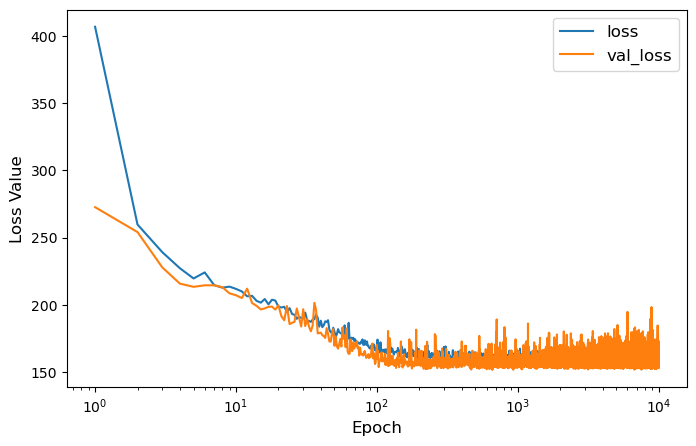

In [18]:
# plot losses against epoch number in log-scale
plt.figure(figsize=(8,5),dpi=100)
plt.semilogx(epoch, loss, linewidth=1.5, label='loss')
plt.semilogx(epoch, val_loss, linewidth=1.5, label='val_loss')
plt.xlabel('Epoch',fontsize=12)
plt.ylabel('Loss Value',fontsize=12)
plt.legend(loc=1,fontsize=12)

Learning rate too high; overshooting porblem occurs

### Evaluation on Test Data

In [19]:
# predicted bike rental rate
y_pred = ann.predict(X_test)

Text(0, 0.5, 'Predicted value')

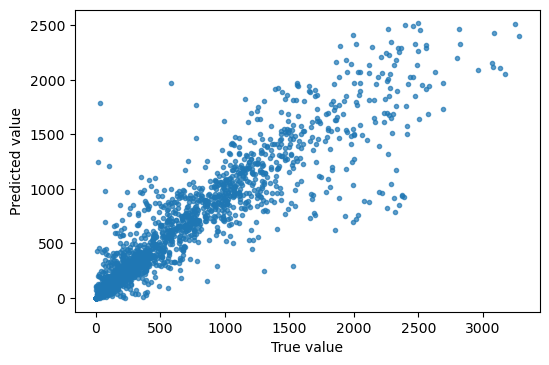

In [20]:
# plot of true rental rate against predicted value 
plt.figure(figsize=(6,4),dpi=100)
plt.plot(y_test.values,y_pred,'o',markersize=3,alpha=0.7)
plt.xlabel('True value')
plt.ylabel('Predicted value')

Text(0, 0.5, 'Probability Distribution')

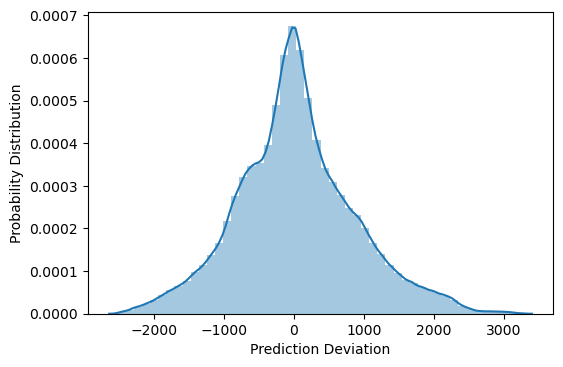

In [21]:
# distribution plot of prediction devations
plt.figure(figsize=(6,4),dpi=100)
sns.distplot(y_test.values-y_pred)
plt.xlabel('Prediction Deviation')
plt.ylabel('Probability Distribution')

Now we compute some performance metric in predicting the test values

In [22]:
from sklearn.metrics import explained_variance_score, r2_score

metric = {'value':[]}

# explained variance
exp_var = round(explained_variance_score(y_test,y_pred),3)
metric['value'].append(exp_var)

# R^2_score
r2 = round(r2_score(y_test,y_pred),3)
metric['value'].append(r2)

df_metric = pd.DataFrame(index=['explained_variance','R_squared'],
                         data=metric,
                         columns=['value'])

In [23]:
df_metric

,value
explained_variance,0.817
R_squared,0.814


Metric values are good